In [1]:
import tracemalloc

from utils_v1 import *
import traceback


In [2]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADistanceMap, PAMultipleDates,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential
from src.trainer.multioutput import TrainerMCDropout, TrainerSingleRun
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric
import json
import pickle 
import src.trainer.evidential as evidential
from src.backend.Logger import Logger
import pdb


In [3]:

config = {
    "training": False,
    "inferring": True,
    "site" : 'PA',
    "training_date": "earlier", # values: earlier, current
    "mode" : 'mcd', # values: mcd, single_run, evidential
    "learning_rate": 1e-4,
    "weights": [0.1, 0.9, 0],
    "save_probabilities": False,
    "loadInference": False,
    "addPastDeforestationInput": True,
    "Uncertainty": {},
    "uncertainty_method": "pred_entropy", # values: pred_entropy, pred_variance, MI, KL
    }
print("Mode: {}. Site: {}. Training: {}. Training date: {}".format(
    config['mode'], config['site'], config['training'], config['training_date']))
print(config)


Mode: mcd. Site: PA. Training: False. Training date: earlier
{'training': False, 'inferring': True, 'site': 'PA', 'training_date': 'earlier', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_method': 'pred_entropy'}


In [4]:


#dates = [2018, 2019]

if config['site'] == 'PA':
	if config['training_date'] == "earlier":
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)


	
	if config['mode'] == 'mcd' or config['mode'] == 'single_run':
		if config['training_date'] == 'current':
			exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122]
		elif config['training_date'] == 'earlier':
			exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]
	if config['mode'] == 'evidential':	
		#exp_id_base = 148
		# exp_id_base = 155
		# exp_id_base = 194
		# exp_id_base = 198

		exp_id_base = 224 if config['training_date'] == 'earlier' else 214
else:
	if config['training_date'] == "earlier":
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	
	if config['mode'] == 'evidential':	

		# MT
		# exp_id_base = 196
		# early date
		exp_id_base = 206
		# early date inference
		exp_id_base = 210
	elif config['mode'] == 'mcd' or config['mode'] == 'single_run':
		if config['training_date'] == 'current':
			exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
		elif config['training_date'] == 'earlier':
			exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	if config['mode'] == 'evidential':
		patchesHandler = PatchesHandlerEvidential(
			dataset)
	else:
		patchesHandler = PatchesHandlerMultipleDates(
			dataset)
		
else:
	patchesHandler = PatchesHandler()



ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2017, 2018]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:


if config['mode'] == 'evidential':
    config["inference_times"] = 1
    config['Uncertainty']['annealing_step'] = 10*375
    config['evidence_function'] = evidential.relu_evidence
    trainer_class = TrainerEvidential
    config['uncertainty_method'] = "evidential"
    config['classes_mode'] = None
    config['evidence_function']

    repetition_n = 10
    # repetition_n = 6

    experiment_values = np.ones(repetition_n).astype(np.uint8)


    # experiment_values = [int(x) for x in experiment_values]

    exp_ids = range(exp_id_base, exp_id_base+len(experiment_values))

if config['mode'] == 'mcd':
    config["inference_times"] = 10
    trainer_class = TrainerMCDropout
    config['uncertainty_method'] = "pred_entropy"
    config['classes_mode'] = False

elif config['mode'] == 'single_run':
    config["inference_times"] = 1
    trainer_class = TrainerSingleRun
    config['uncertainty_method'] = "pred_entropy_single"
    config['classes_mode'] = False



In [6]:
exp_ids

[123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]

In [7]:
if config['training'] == True:
    idx = 0
    error_count = 0

    while idx < len(exp_ids):
    # for experiment_value, exp_id in zip(experiment_values, exp_ids):
        try:

            print("Beginning run number {}".format(idx))
            logger = Logger()
            trainer = trainer_class(config, dataset, patchesHandler, logger)

            trainer.defineExperiment(exp_ids[idx])

            trainer.setExperimentPath()
            trainer.createLogFolders()

            trainer.loadDataset()

            # %%
            if config["training"] == True:
                trainer.run()
            idx += 1
            print("Grid execution idx: {}".format(idx))            
        except Exception as e: 
            print(traceback.format_exc())
            error_count += 1
            if error_count > 10:
                sys.exit()
            print("Execution error in idx {}. Retrying...".format(idx))
            continue


In [8]:

if config['site'] == 'PA':

	dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	

elif config['site'] == 'MT':

	dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	


ic(dates)

if issubclass(type(dataset), MultipleDates):
	if config['mode'] == 'evidential':
		patchesHandler = PatchesHandlerEvidential(
			dataset)
	else:
		patchesHandler = PatchesHandlerMultipleDates(
			dataset)
		
else:
	patchesHandler = PatchesHandler()



ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [9]:
trainer_class

src.trainer.multioutput.TrainerMCDropout

Beginning run number 0
trainer.config {'training': False, 'inferring': True, 'site': 'PA', 'training_date': 'earlier', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_method': 'pred_entropy', 'inference_times': 10, 'classes_mode': False, 'dropout_training': True}
D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp123/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161655761,   1460239], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161655761,   1460239], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161790167,   1325833], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162981594,    134406], dtype=int64))
ic| self.f1: 79.45, self.precision: 94.37, self.recall: 68.6
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9438390,)
ic| f1_val: 83.65
    precision_val: 89.93
    recall_val: 78.19
    mAP_val: 85.38


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162376401,    739599], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54176594,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54176594,) (54176594,)
0.686983820139951
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.02294899479640936
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1957083,)
    predicted_test_classified_incorrect.shape: (1957083,)
ic| TP_H + FN_H + FP_H + TN_H: 1957083
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1957083
    len(label_mask_current_deforestation_test): 54176594


[0.99036172 0.8881414  0.42609596 0.03612414 0.8760346  0.49955241
 0.1100629 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1115599,)
    predicted_test_classified_incorrect.shape: (1115599,)
ic| TP_H + FN_H + FP_H + TN_H: 1115599
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1115599
    len(label_mask_current_deforestation_test): 54176594


[0.98019977 0.85971465 0.52537486 0.0205919  0.84124044 0.41298304
 0.16139667]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (2945170,)
    predicted_test_classified_incorrect.shape: (2945170,)
ic| TP_H + FN_H + FP_H + TN_H: 2945170
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 2945170
    len(label_mask_current_deforestation_test): 54176594


[0.99579339 0.90812892 0.34382812 0.05436241 0.89657319 0.55062868
 0.07944108]
0.2552760614830532
threshold 0.2552760614830532


ic| label_current_deforestation_test_classified_incorrect.shape: (1537304,)
    predicted_test_classified_incorrect.shape: (1537304,)
ic| TP_H + FN_H + FP_H + TN_H: 1537304
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1537304
    len(label_mask_current_deforestation_test): 54176594


[0.98593202 0.87613517 0.47065247 0.0283758  0.86291788 0.46526801
 0.13111314]
0.2568939962070309
threshold 0.2568939962070309


ic| label_current_deforestation_test_classified_incorrect.shape: (1526197,)
    predicted_test_classified_incorrect.shape: (1526197,)
ic| TP_H + FN_H + FP_H + TN_H: 1526197
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1526197
    len(label_mask_current_deforestation_test): 54176594


[0.98579864 0.8757271  0.4718849  0.02817078 0.86252352 0.46426794
 0.13176531]
0.2400716075188234
threshold 0.2400716075188234


ic| label_current_deforestation_test_classified_incorrect.shape: (1646177,)
    predicted_test_classified_incorrect.shape: (1646177,)
ic| TP_H + FN_H + FP_H + TN_H: 1646177
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1646177
    len(label_mask_current_deforestation_test): 54176594


[0.98707652 0.87959934 0.45838755 0.03038539 0.86697519 0.47527703
 0.12492804]
0.22594128077145478
threshold 0.22594128077145478


ic| label_current_deforestation_test_classified_incorrect.shape: (1757175,)
    predicted_test_classified_incorrect.shape: (1757175,)
ic| TP_H + FN_H + FP_H + TN_H: 1757175
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1757175
    len(label_mask_current_deforestation_test): 54176594


[0.98828966 0.88293051 0.44657349 0.03243421 0.87045099 0.48442314
 0.1192043 ]
0.23252429084978748
threshold 0.23252429084978748


ic| label_current_deforestation_test_classified_incorrect.shape: (1704242,)
    predicted_test_classified_incorrect.shape: (1704242,)
ic| TP_H + FN_H + FP_H + TN_H: 1704242
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1704242
    len(label_mask_current_deforestation_test): 54176594


[0.98773641 0.8814714  0.45217275 0.03145716 0.86879909 0.48007727
 0.12189839]
0.24352645902285258
threshold 0.24352645902285258


ic| label_current_deforestation_test_classified_incorrect.shape: (1620465,)
    predicted_test_classified_incorrect.shape: (1620465,)
ic| TP_H + FN_H + FP_H + TN_H: 1620465
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1620465
    len(label_mask_current_deforestation_test): 54176594


[0.9868179  0.87886006 0.46120068 0.0299108  0.86606544 0.47299712
 0.12635793]
0.24801440780834982
threshold 0.24801440780834982


ic| label_current_deforestation_test_classified_incorrect.shape: (1588227,)
    predicted_test_classified_incorrect.shape: (1588227,)
ic| TP_H + FN_H + FP_H + TN_H: 1588227
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1588227
    len(label_mask_current_deforestation_test): 54176594


[0.98648567 0.87783473 0.46488583 0.02931574 0.86483904 0.47000066
 0.12816226]
0.24335853521586617
threshold 0.24335853521586617


ic| label_current_deforestation_test_classified_incorrect.shape: (1621691,)
    predicted_test_classified_incorrect.shape: (1621691,)
ic| TP_H + FN_H + FP_H + TN_H: 1621691
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1621691
    len(label_mask_current_deforestation_test): 54176594


[0.98683675 0.87889775 0.4610603  0.02993342 0.86610183 0.4731111
 0.1262916 ]
0.24243803542908662
threshold 0.24243803542908662


ic| label_current_deforestation_test_classified_incorrect.shape: (1628532,)
    predicted_test_classified_incorrect.shape: (1628532,)
ic| TP_H + FN_H + FP_H + TN_H: 1628532
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1628532
    len(label_mask_current_deforestation_test): 54176594


[0.98688452 0.87909918 0.46032462 0.0300597  0.8663723  0.47370494
 0.12590337]
0.24153414039929247
threshold 0.24153414039929247


ic| label_current_deforestation_test_classified_incorrect.shape: (1635246,)
    predicted_test_classified_incorrect.shape: (1635246,)
ic| TP_H + FN_H + FP_H + TN_H: 1635246
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1635246
    len(label_mask_current_deforestation_test): 54176594


[0.98696111 0.87928804 0.45959029 0.03018363 0.86659571 0.47430296
 0.12553032]
0.2428663383461751
threshold 0.2428663383461751


ic| label_current_deforestation_test_classified_incorrect.shape: (1625325,)
    predicted_test_classified_incorrect.shape: (1625325,)
ic| TP_H + FN_H + FP_H + TN_H: 1625325
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1625325
    len(label_mask_current_deforestation_test): 54176594


[0.98687384 0.87900565 0.46065533 0.0300005  0.86623387 0.47344
 0.1260891 ]
0.24289967528179837
threshold 0.24289967528179837


ic| label_current_deforestation_test_classified_incorrect.shape: (1625066,)
    predicted_test_classified_incorrect.shape: (1625066,)
ic| TP_H + FN_H + FP_H + TN_H: 1625066
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1625066
    len(label_mask_current_deforestation_test): 54176594


[0.98686611 0.87900345 0.46068503 0.02999572 0.86623209 0.47341251
 0.12610388]
0.24277902377592667
threshold 0.24277902377592667


ic| label_current_deforestation_test_classified_incorrect.shape: (1625983,)
    predicted_test_classified_incorrect.shape: (1625983,)
ic| TP_H + FN_H + FP_H + TN_H: 1625983
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1625983
    len(label_mask_current_deforestation_test): 54176594


[0.98687476 0.87902145 0.46058649 0.03001265 0.86626477 0.47349735
 0.12604971]
0.2428329871480533
threshold 0.2428329871480533


ic| label_current_deforestation_test_classified_incorrect.shape: (1625552,)
    predicted_test_classified_incorrect.shape: (1625552,)
ic| TP_H + FN_H + FP_H + TN_H: 1625552
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1625552
    len(label_mask_current_deforestation_test): 54176594
ic| self.threshold_optimal: 0.2428663383461751


[0.98687624 0.87901323 0.46063914 0.03000469 0.86623771 0.4734512
 0.12607607]
threshold 0.2428663383461751


ic| label_current_deforestation_test_classified_incorrect.shape: (1625325,)
    predicted_test_classified_incorrect.shape: (1625325,)
ic| TP_H + FN_H + FP_H + TN_H: 1625325
    len(label_mask_current_deforestation_test): 54176594
ic| TP_H + FN_H + FP_H + TN_H: 1625325
    len(label_mask_current_deforestation_test): 54176594


[0.98687384 0.87900565 0.46065533 0.0300005  0.86623387 0.47344
 0.1260891 ]
threshold 0.2428663383461751
(54176594,) (54176594,)


ic| self.m_optimal: {'AA': array([0.0300005]),
                     'UEO': array([0.1260891]),
                     'f1': 79.45,
                     'f1_H': array([0.61225313]),
                     'f1_L': array([0.92982177]),
                     'precision_H': array([0.86623387]),
                     'precision_L': array([0.98687384]),
                     'recall_H': array([0.47344]),
                     'recall_L': array([0.87900565]),
                     'recall_Ltotal': array([0.46065533])}
ic| self.m_audited_optimal: {'f1': array([0.96420692]),
                             'precision': array([0.99350065]),
                             'recall': array([0.9365912])}


cm_audited [[53431243     4539]
 [   46974   693838]]
[0.99350065 0.9365912 ]
Result idx 0: {'other_uncertainty_metrics': {'sUEO': 0.686983820139951, 'ece_score': 0.02294899479640936}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.5908910e-02],
       [9.7153952e-06],
       [1.2918716e-04],
       [4.4166594e-05],
       [2.4157283e-05],
       [6.8640671e-05],
       [2.8585206e-04],
       [2.3970329e-04],
       [3.1868738e-05],
       [7.2862786e-05]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.3473176 ],
       [0.32531524],
       [0.15975878],
       [0.24941336],
       [0.10007419],
       [0.2588972 ],
       [0.2931811 ],
       [0.35460928],
       [0.31854057],
       [0.3372865 ]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.24558604],
       [0.09796154],
       [0.00637373],
       [0.06730682],
       [0.0027

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp124/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161456832,   1659168], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161456832,   1659168], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161629672,   1486328], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162943160,    172840], dtype=int64))
ic| self.f1: 81.54, self.precision: 92.69, self.recall: 72.78
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9429309,)
ic| f1_val: 83.2
    precision_val: 84.01
    recall_val: 82.41
    mAP_val: 83.1


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162409106,    706894], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54167222,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54167222,) (54167222,)
0.7138840143441434
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.015648782352900625
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1843426,)
    predicted_test_classified_incorrect.shape: (1843426,)
ic| TP_H + FN_H + FP_H + TN_H: 1843426
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1843426
    len(label_mask_current_deforestation_test): 54167222


[0.96967313 0.90225503 0.48012682 0.03403213 0.85389239 0.52933745
 0.10255501]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1111569,)
    predicted_test_classified_incorrect.shape: (1111569,)
ic| TP_H + FN_H + FP_H + TN_H: 1111569
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1111569
    len(label_mask_current_deforestation_test): 54167222


[0.95816939 0.88055436 0.58927175 0.02052106 0.8139217  0.41872028
 0.13917526]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (2585384,)
    predicted_test_classified_incorrect.shape: (2585384,)
ic| TP_H + FN_H + FP_H + TN_H: 2585384
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 2585384
    len(label_mask_current_deforestation_test): 54167222


[0.97907282 0.91929359 0.40568319 0.04772968 0.8686137  0.57651385
 0.08057287]
0.24548556730033647
threshold 0.24548556730033647


ic| label_current_deforestation_test_classified_incorrect.shape: (1553710,)
    predicted_test_classified_incorrect.shape: (1553710,)
ic| TP_H + FN_H + FP_H + TN_H: 1553710
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1553710
    len(label_mask_current_deforestation_test): 54167222


[0.96613139 0.89502774 0.51909546 0.02868358 0.84188183 0.49684581
 0.11489254]
0.24869878748934685
threshold 0.24869878748934685


ic| label_current_deforestation_test_classified_incorrect.shape: (1534043,)
    predicted_test_classified_incorrect.shape: (1534043,)
ic| TP_H + FN_H + FP_H + TN_H: 1534043
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1534043
    len(label_mask_current_deforestation_test): 54167222


[0.96585398 0.89447763 0.52199941 0.0283205  0.84088962 0.49417134
 0.11581606]
0.23253295106807112
threshold 0.23253295106807112


ic| label_current_deforestation_test_classified_incorrect.shape: (1635726,)
    predicted_test_classified_incorrect.shape: (1635726,)
ic| TP_H + FN_H + FP_H + TN_H: 1635726
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1635726
    len(label_mask_current_deforestation_test): 54167222


[0.96713565 0.89707805 0.50773124 0.03019771 0.84573318 0.5070103
 0.11106323]
0.22128213485538123
threshold 0.22128213485538123


ic| label_current_deforestation_test_classified_incorrect.shape: (1711206,)
    predicted_test_classified_incorrect.shape: (1711206,)
ic| TP_H + FN_H + FP_H + TN_H: 1711206
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1711206
    len(label_mask_current_deforestation_test): 54167222


[0.96801021 0.89904916 0.49748559 0.03159117 0.84902565 0.51560437
 0.10780428]
0.2340373321471848
threshold 0.2340373321471848


ic| label_current_deforestation_test_classified_incorrect.shape: (1625913,)
    predicted_test_classified_incorrect.shape: (1625913,)
ic| TP_H + FN_H + FP_H + TN_H: 1625913
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1625913
    len(label_mask_current_deforestation_test): 54167222


[0.96699601 0.89683328 0.50911626 0.03001655 0.84530962 0.50579891
 0.11149781]
0.23661850589778594
threshold 0.23661850589778594


ic| label_current_deforestation_test_classified_incorrect.shape: (1609251,)
    predicted_test_classified_incorrect.shape: (1609251,)
ic| TP_H + FN_H + FP_H + TN_H: 1609251
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1609251
    len(label_mask_current_deforestation_test): 54167222


[0.966797   0.89641755 0.51135611 0.02970894 0.84456877 0.50383674
 0.11226403]
0.23436991309843583
threshold 0.23436991309843583


ic| label_current_deforestation_test_classified_incorrect.shape: (1623677,)
    predicted_test_classified_incorrect.shape: (1623677,)
ic| TP_H + FN_H + FP_H + TN_H: 1623677
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1623677
    len(label_mask_current_deforestation_test): 54167222


[0.96696613 0.89677662 0.50939219 0.02997527 0.8452285  0.50556243
 0.11160056]
0.23407066895185275
threshold 0.23407066895185275


ic| label_current_deforestation_test_classified_incorrect.shape: (1625683,)
    predicted_test_classified_incorrect.shape: (1625683,)
ic| TP_H + FN_H + FP_H + TN_H: 1625683
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1625683
    len(label_mask_current_deforestation_test): 54167222


[0.96698975 0.8968239  0.5091352  0.0300123  0.84531155 0.50578676
 0.11150711]
0.23417939576670901
threshold 0.23417939576670901


ic| label_current_deforestation_test_classified_incorrect.shape: (1624953,)
    predicted_test_classified_incorrect.shape: (1624953,)
ic| TP_H + FN_H + FP_H + TN_H: 1624953
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1624953
    len(label_mask_current_deforestation_test): 54167222


[0.96698403 0.89680487 0.50924205 0.02999882 0.84526973 0.50569306
 0.11154032]
0.23425216691198272
threshold 0.23425216691198272


ic| label_current_deforestation_test_classified_incorrect.shape: (1624459,)
    predicted_test_classified_incorrect.shape: (1624459,)
ic| TP_H + FN_H + FP_H + TN_H: 1624459
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1624459
    len(label_mask_current_deforestation_test): 54167222


[0.96697799 0.89679695 0.50930427 0.0299897  0.84525018 0.50563613
 0.11156451]
0.23414605895993393
threshold 0.23414605895993393


ic| label_current_deforestation_test_classified_incorrect.shape: (1625177,)
    predicted_test_classified_incorrect.shape: (1625177,)
ic| TP_H + FN_H + FP_H + TN_H: 1625177
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1625177
    len(label_mask_current_deforestation_test): 54167222


[0.96698448 0.89680965 0.50920959 0.03000296 0.84528474 0.50572227
 0.11152943]
0.2342127325734841
threshold 0.2342127325734841


ic| label_current_deforestation_test_classified_incorrect.shape: (1624728,)
    predicted_test_classified_incorrect.shape: (1624728,)
ic| TP_H + FN_H + FP_H + TN_H: 1624728
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1624728
    len(label_mask_current_deforestation_test): 54167222
ic| self.threshold_optimal: 0.23417939576670901


[0.9669811  0.89680009 0.50927451 0.02999467 0.84525915 0.50566384
 0.11155062]
threshold 0.23417939576670901


ic| label_current_deforestation_test_classified_incorrect.shape: (1624953,)
    predicted_test_classified_incorrect.shape: (1624953,)
ic| TP_H + FN_H + FP_H + TN_H: 1624953
    len(label_mask_current_deforestation_test): 54167222
ic| TP_H + FN_H + FP_H + TN_H: 1624953
    len(label_mask_current_deforestation_test): 54167222


[0.96698403 0.89680487 0.50924205 0.02999882 0.84526973 0.50569306
 0.11154032]
threshold 0.23417939576670901
(54167222,) (54167222,)


ic| self.m_optimal: {'AA': array([0.02999882]),
                     'UEO': array([0.11154032]),
                     'f1': 81.54,
                     'f1_H': array([0.63280357]),
                     'f1_L': array([0.93057318]),
                     'precision_H': array([0.84526973]),
                     'precision_L': array([0.96698403]),
                     'recall_H': array([0.50569306]),
                     'recall_L': array([0.89680487]),
                     'recall_Ltotal': array([0.50924205])}
ic| self.m_audited_optimal: {'f1': array([0.96120789]),
                             'precision': array([0.98186548]),
                             'recall': array([0.94140163])}


cm_audited [[53415029    12855]
 [   43324   696014]]
[0.98186548 0.94140163]
Result idx 1: {'other_uncertainty_metrics': {'sUEO': 0.7138840143441434, 'ece_score': 0.015648782352900625}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[6.2610638e-08],
       [1.6323427e-06],
       [7.1555036e-08],
       [1.0953936e-09],
       [3.2633073e-07],
       [1.9091815e-06],
       [1.4248143e-06],
       [6.0227725e-09],
       [4.9326029e-08],
       [1.0444294e-07]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.02074104],
       [0.10622913],
       [0.00684132],
       [0.1871057 ],
       [0.16476382],
       [0.00822231],
       [0.03316607],
       [0.12860966],
       [0.00915366],
       [0.00240754]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.00352151],
       [0.03131539],
       [0.00043584],
       [0.06176784],
       [0.03

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp125/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161678855,   1437145], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161678855,   1437145], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161876900,   1239100], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162917955,    198045], dtype=int64))
ic| self.f1: 78.32, self.precision: 95.52, self.recall: 66.37
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9427193,)
ic| f1_val: 74.98
    precision_val: 87.29
    recall_val: 65.71
    mAP_val: 84.06


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162328858,    787142], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54144742,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54144742,) (54144742,)
0.7175056169708631
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.012377167104619802
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1496188,)
    predicted_test_classified_incorrect.shape: (1496188,)
ic| TP_H + FN_H + FP_H + TN_H: 1496188
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1496188
    len(label_mask_current_deforestation_test): 54144742


[0.99554481 0.84542265 0.41387027 0.02763312 0.89516376 0.48936498
 0.13745549]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (894860,)
    predicted_test_classified_incorrect.shape: (894860,)
ic| TP_H + FN_H + FP_H + TN_H: 894860
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 894860
    len(label_mask_current_deforestation_test): 54144742


[0.98390791 0.82641012 0.52553388 0.01652718 0.85986814 0.37941632
 0.18623453]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (2100394,)
    predicted_test_classified_incorrect.shape: (2100394,)
ic| TP_H + FN_H + FP_H + TN_H: 2100394
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 2100394
    len(label_mask_current_deforestation_test): 54144742


[0.99956441 0.85524639 0.32717091 0.03879221 0.91573424 0.54497873
 0.10727882]
0.21331151544501087
threshold 0.21331151544501087


ic| label_current_deforestation_test_classified_incorrect.shape: (1435872,)
    predicted_test_classified_incorrect.shape: (1435872,)
ic| TP_H + FN_H + FP_H + TN_H: 1435872
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1435872
    len(label_mask_current_deforestation_test): 54144742


[0.99478629 0.84396042 0.42411804 0.02651914 0.89239773 0.48154416
 0.14125589]
0.18350644306423114
threshold 0.18350644306423114


ic| label_current_deforestation_test_classified_incorrect.shape: (1620873,)
    predicted_test_classified_incorrect.shape: (1620873,)
ic| TP_H + FN_H + FP_H + TN_H: 1620873
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1620873
    len(label_mask_current_deforestation_test): 54144742


[0.99691972 0.84733204 0.39332177 0.02993593 0.90044005 0.50455905
 0.12994054]
0.16157226265899413
threshold 0.16157226265899413


ic| label_current_deforestation_test_classified_incorrect.shape: (1779446,)
    predicted_test_classified_incorrect.shape: (1779446,)
ic| TP_H + FN_H + FP_H + TN_H: 1779446
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1779446
    len(label_mask_current_deforestation_test): 54144742


[0.99834279 0.85008242 0.36973846 0.03286461 0.90600777 0.52018206
 0.12151906]
0.18333946304655174
threshold 0.18333946304655174


ic| label_current_deforestation_test_classified_incorrect.shape: (1622027,)
    predicted_test_classified_incorrect.shape: (1622027,)
ic| TP_H + FN_H + FP_H + TN_H: 1622027
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1622027
    len(label_mask_current_deforestation_test): 54144742


[0.99692516 0.84737632 0.39313982 0.02995724 0.90049221 0.50467354
 0.1298807 ]
0.1750251323384346
threshold 0.1750251323384346


ic| label_current_deforestation_test_classified_incorrect.shape: (1679707,)
    predicted_test_classified_incorrect.shape: (1679707,)
ic| TP_H + FN_H + FP_H + TN_H: 1679707
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1679707
    len(label_mask_current_deforestation_test): 54144742


[0.99746621 0.84846432 0.38433681 0.03102253 0.9026353  0.51064527
 0.12670814]
0.18121799417225581
threshold 0.18121799417225581


ic| label_current_deforestation_test_classified_incorrect.shape: (1636387,)
    predicted_test_classified_incorrect.shape: (1636387,)
ic| TP_H + FN_H + FP_H + TN_H: 1636387
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1636387
    len(label_mask_current_deforestation_test): 54144742


[0.99708049 0.84772642 0.3909333  0.03022245 0.90101559 0.50615119
 0.12909953]
0.18273515617217126
threshold 0.18273515617217126


ic| label_current_deforestation_test_classified_incorrect.shape: (1626104,)
    predicted_test_classified_incorrect.shape: (1626104,)
ic| TP_H + FN_H + FP_H + TN_H: 1626104
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1626104
    len(label_mask_current_deforestation_test): 54144742


[0.9969717  0.84746935 0.39249484 0.03003254 0.90064445 0.50511162
 0.12965818]
0.18297838875091615
threshold 0.18297838875091615


ic| label_current_deforestation_test_classified_incorrect.shape: (1624513,)
    predicted_test_classified_incorrect.shape: (1624513,)
ic| TP_H + FN_H + FP_H + TN_H: 1624513
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1624513
    len(label_mask_current_deforestation_test): 54144742


[0.99695643 0.84742202 0.39274333 0.03000315 0.90058271 0.50494889
 0.12974277]
0.183015133932946
threshold 0.183015133932946


ic| label_current_deforestation_test_classified_incorrect.shape: (1624256,)
    predicted_test_classified_incorrect.shape: (1624256,)
ic| TP_H + FN_H + FP_H + TN_H: 1624256
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1624256
    len(label_mask_current_deforestation_test): 54144742


[0.99694998 0.84741756 0.39279764 0.02999841 0.90057289 0.50491027
 0.12975524]
0.18307263266262142
threshold 0.18307263266262142


ic| label_current_deforestation_test_classified_incorrect.shape: (1623878,)
    predicted_test_classified_incorrect.shape: (1623878,)
ic| TP_H + FN_H + FP_H + TN_H: 1623878
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1623878
    len(label_mask_current_deforestation_test): 54144742
ic| self.threshold_optimal: 0.183015133932946


[0.99694693 0.84741672 0.39284788 0.02999143 0.90056034 0.50487285
 0.1297791 ]
threshold 0.183015133932946


ic| label_current_deforestation_test_classified_incorrect.shape: (1624256,)
    predicted_test_classified_incorrect.shape: (1624256,)
ic| TP_H + FN_H + FP_H + TN_H: 1624256
    len(label_mask_current_deforestation_test): 54144742
ic| TP_H + FN_H + FP_H + TN_H: 1624256
    len(label_mask_current_deforestation_test): 54144742


[0.99694998 0.84741756 0.39279764 0.02999841 0.90057289 0.50491027
 0.12975524]
threshold 0.183015133932946
(54144742,) (54144742,)


ic| self.m_optimal: {'AA': array([0.02999841]),
                     'UEO': array([0.12975524]),
                     'f1': 78.32,
                     'f1_H': array([0.64704938]),
                     'f1_L': array([0.91612209]),
                     'precision_H': array([0.90057289]),
                     'precision_L': array([0.99694998]),
                     'recall_H': array([0.50491027]),
                     'recall_L': array([0.84741756]),
                     'recall_Ltotal': array([0.39279764])}
ic| self.m_audited_optimal: {'f1': array([0.96274122]),
                             'precision': array([0.9987085]),
                             'recall': array([0.92927451])}


cm_audited [[53407404      885]
 [   52086   684367]]
[0.9987085  0.92927451]
Result idx 2: {'other_uncertainty_metrics': {'sUEO': 0.7175056169708631, 'ece_score': 0.012377167104619802}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[3.0454492e-10],
       [2.4725227e-06],
       [7.1466004e-04],
       [1.7821593e-08],
       [3.6310194e-05],
       [9.7177310e-12],
       [3.0564572e-04],
       [1.5361683e-06],
       [6.1294479e-08],
       [1.1338950e-04]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.05523838],
       [0.08372477],
       [0.16429493],
       [0.02116595],
       [0.13805188],
       [0.01792312],
       [0.11203498],
       [0.13859822],
       [0.06274789],
       [0.1903098 ]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[1.2552894e-04],
       [1.3254151e-03],
       [3.8499605e-02],
       [3.1922138e-04],


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp126/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161815581,   1300419], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161815581,   1300419], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161934709,   1181291], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162996872,    119128], dtype=int64))
ic| self.f1: 74.94, self.precision: 96.7, self.recall: 61.18
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9440217,)
ic| f1_val: 80.11
    precision_val: 89.29
    recall_val: 72.63
    mAP_val: 83.68


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162290169,    825831], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54187563,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54187563,) (54187563,)
0.6336440042137966
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.02649013999322936
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (2196566,)
    predicted_test_classified_incorrect.shape: (2196566,)
ic| TP_H + FN_H + FP_H + TN_H: 2196566
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 2196566
    len(label_mask_current_deforestation_test): 54187563


[0.99414247 0.8761182  0.38129504 0.04053635 0.92529921 0.4080694
 0.11720568]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1256702,)
    predicted_test_classified_incorrect.shape: (1256702,)
ic| TP_H + FN_H + FP_H + TN_H: 1256702
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1256702
    len(label_mask_current_deforestation_test): 54187563


[0.986239   0.83636569 0.47734895 0.02319171 0.90449896 0.31314442
 0.17257918]
0.4046558636441412
threshold 0.4046558636441412


ic| label_current_deforestation_test_classified_incorrect.shape: (861393,)
    predicted_test_classified_incorrect.shape: (861393,)
ic| TP_H + FN_H + FP_H + TN_H: 861393
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 861393
    len(label_mask_current_deforestation_test): 54187563


[0.97928278 0.81128671 0.534663   0.01589651 0.88987564 0.22613698
 0.21120729]
0.2895608280387265
threshold 0.2895608280387265


ic| label_current_deforestation_test_classified_incorrect.shape: (1486483,)
    predicted_test_classified_incorrect.shape: (1486483,)
ic| TP_H + FN_H + FP_H + TN_H: 1486483
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1486483
    len(label_mask_current_deforestation_test): 54187563


[0.98851968 0.84770657 0.44886277 0.02743218 0.91240271 0.34624193
 0.1549841 ]
0.2745314315522572
threshold 0.2745314315522572


ic| label_current_deforestation_test_classified_incorrect.shape: (1586776,)
    predicted_test_classified_incorrect.shape: (1586776,)
ic| TP_H + FN_H + FP_H + TN_H: 1586776
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1586776
    len(label_mask_current_deforestation_test): 54187563


[0.98941757 0.8526262  0.43795933 0.02928303 0.91489106 0.35738193
 0.1483952 ]
0.24723862327045737
threshold 0.24723862327045737


ic| label_current_deforestation_test_classified_incorrect.shape: (1791311,)
    predicted_test_classified_incorrect.shape: (1791311,)
ic| TP_H + FN_H + FP_H + TN_H: 1791311
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1791311
    len(label_mask_current_deforestation_test): 54187563


[0.9912881  0.86160504 0.41758246 0.0330576  0.91870545 0.37680936
 0.13639746]
0.2695719707658007
threshold 0.2695719707658007


ic| label_current_deforestation_test_classified_incorrect.shape: (1621778,)
    predicted_test_classified_incorrect.shape: (1621778,)
ic| TP_H + FN_H + FP_H + TN_H: 1621778
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1621778
    len(label_mask_current_deforestation_test): 54187563


[0.9897314  0.85420884 0.43424233 0.02992897 0.91567845 0.3610874
 0.14620058]
0.2610413911051419
threshold 0.2610413911051419


ic| label_current_deforestation_test_classified_incorrect.shape: (1683752,)
    predicted_test_classified_incorrect.shape: (1683752,)
ic| TP_H + FN_H + FP_H + TN_H: 1683752
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1683752
    len(label_mask_current_deforestation_test): 54187563


[0.99032167 0.85687658 0.42796394 0.03107267 0.91684449 0.36720302
 0.1424399 ]
0.2685045177424715
threshold 0.2685045177424715


ic| label_current_deforestation_test_classified_incorrect.shape: (1629440,)
    predicted_test_classified_incorrect.shape: (1629440,)
ic| TP_H + FN_H + FP_H + TN_H: 1629440
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1629440
    len(label_mask_current_deforestation_test): 54187563


[0.98978767 0.85455361 0.43340019 0.03007037 0.91588495 0.36192387
 0.1457297 ]
0.2690238640293371
threshold 0.2690238640293371


ic| label_current_deforestation_test_classified_incorrect.shape: (1625661,)
    predicted_test_classified_incorrect.shape: (1625661,)
ic| TP_H + FN_H + FP_H + TN_H: 1625661
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1625661
    len(label_mask_current_deforestation_test): 54187563


[0.98976078 0.85439265 0.4338105  0.03000063 0.91578343 0.36151368
 0.14596488]
0.26905720135293915
threshold 0.26905720135293915


ic| label_current_deforestation_test_classified_incorrect.shape: (1625418,)
    predicted_test_classified_incorrect.shape: (1625418,)
ic| TP_H + FN_H + FP_H + TN_H: 1625418
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1625418
    len(label_mask_current_deforestation_test): 54187563


[0.98975846 0.85438568 0.43384144 0.02999615 0.91577635 0.36148046
 0.1459805 ]
0.268924806926491
threshold 0.268924806926491


ic| label_current_deforestation_test_classified_incorrect.shape: (1626355,)
    predicted_test_classified_incorrect.shape: (1626355,)
ic| TP_H + FN_H + FP_H + TN_H: 1626355
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1626355
    len(label_mask_current_deforestation_test): 54187563


[0.98976525 0.85442731 0.43374189 0.03001344 0.91580047 0.36157894
 0.14592244]
0.268986027582877
threshold 0.268986027582877


ic| label_current_deforestation_test_classified_incorrect.shape: (1625921,)
    predicted_test_classified_incorrect.shape: (1625921,)
ic| TP_H + FN_H + FP_H + TN_H: 1625921
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1625921
    len(label_mask_current_deforestation_test): 54187563
ic| self.threshold_optimal: 0.2690238640293371


[0.98976619 0.85440266 0.43378225 0.03000543 0.91578299 0.36154241
 0.14594915]
threshold 0.2690238640293371


ic| label_current_deforestation_test_classified_incorrect.shape: (1625661,)
    predicted_test_classified_incorrect.shape: (1625661,)
ic| TP_H + FN_H + FP_H + TN_H: 1625661
    len(label_mask_current_deforestation_test): 54187563
ic| TP_H + FN_H + FP_H + TN_H: 1625661
    len(label_mask_current_deforestation_test): 54187563


[0.98976078 0.85439265 0.4338105  0.03000063 0.91578343 0.36151368
 0.14596488]
threshold 0.2690238640293371
(54187563,) (54187563,)


ic| self.m_optimal: {'AA': array([0.03000063]),
                     'UEO': array([0.14596488]),
                     'f1': 74.94,
                     'f1_H': array([0.51838876]),
                     'f1_L': array([0.91710844]),
                     'precision_H': array([0.91578343]),
                     'precision_L': array([0.98976078]),
                     'recall_H': array([0.36151368]),
                     'recall_L': array([0.85439265]),
                     'recall_Ltotal': array([0.4338105])}
ic| self.m_audited_optimal: {'f1': array([0.95938027]),
                             'precision': array([0.99517726]),
                             'recall': array([0.92606912])}


cm_audited [[53440884     3336]
 [   54956   688387]]
[0.99517726 0.92606912]
Result idx 3: {'other_uncertainty_metrics': {'sUEO': 0.6336440042137966, 'ece_score': 0.02649013999322936}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.4988722e-02],
       [5.1957927e-06],
       [4.9013644e-05],
       [8.3217146e-06],
       [8.6817629e-09],
       [3.7037834e-04],
       [7.7342878e-07],
       [2.8503769e-06],
       [5.6002340e-05],
       [2.8122013e-06]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.2922528 ],
       [0.23019317],
       [0.18211247],
       [0.04258023],
       [0.02587945],
       [0.10041248],
       [0.15483488],
       [0.04888983],
       [0.15449622],
       [0.14659488]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.11731874],
       [0.03721554],
       [0.00479291],
       [0.00080636],
       [0.000

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp127/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161816610,   1299390], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161816610,   1299390], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161918901,   1197099], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163013709,    102291], dtype=int64))
ic| self.f1: 77.1, self.precision: 98.06, self.recall: 63.52
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9440208,)
ic| f1_val: 83.73
    precision_val: 92.53
    recall_val: 76.46
    mAP_val: 87.53


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162333205,    782795], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54188047,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54188047,) (54188047,)
0.6517494791170902
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.027473956826752365
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (2035257,)
    predicted_test_classified_incorrect.shape: (2035257,)
ic| TP_H + FN_H + FP_H + TN_H: 2035257
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 2035257
    len(label_mask_current_deforestation_test): 54188047


[0.99975973 0.88999416 0.37595155 0.03755915 0.95404763 0.44886833
 0.11852112]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1171560,)
    predicted_test_classified_incorrect.shape: (1171560,)
ic| TP_H + FN_H + FP_H + TN_H: 1171560
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1171560
    len(label_mask_current_deforestation_test): 54188047


[0.99488752 0.85165529 0.46763616 0.02162027 0.94275808 0.37163288
 0.17641733]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (3117667,)
    predicted_test_classified_incorrect.shape: (3117667,)
ic| TP_H + FN_H + FP_H + TN_H: 3117667
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 3117667
    len(label_mask_current_deforestation_test): 54188047


[1.         0.91192184 0.30613051 0.05753422 0.96318619 0.49537468
 0.08214855]
0.262873360304018
threshold 0.262873360304018


ic| label_current_deforestation_test_classified_incorrect.shape: (1558012,)
    predicted_test_classified_incorrect.shape: (1558012,)
ic| TP_H + FN_H + FP_H + TN_H: 1558012
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1558012
    len(label_mask_current_deforestation_test): 54188047


[0.99811292 0.87173594 0.41939551 0.02875195 0.94822131 0.41590846
 0.14553529]
0.26346613150969667
threshold 0.26346613150969667


ic| label_current_deforestation_test_classified_incorrect.shape: (1554003,)
    predicted_test_classified_incorrect.shape: (1554003,)
ic| TP_H + FN_H + FP_H + TN_H: 1554003
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1554003
    len(label_mask_current_deforestation_test): 54188047


[0.99808907 0.87154232 0.41978658 0.02867797 0.94817721 0.41559979
 0.14580679]
0.24681016031601052
threshold 0.24681016031601052


ic| label_current_deforestation_test_classified_incorrect.shape: (1671283,)
    predicted_test_classified_incorrect.shape: (1671283,)
ic| TP_H + FN_H + FP_H + TN_H: 1671283
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1671283
    len(label_mask_current_deforestation_test): 54188047


[0.99863724 0.87678567 0.40812727 0.03084228 0.94972562 0.42483362
 0.13819348]
0.2301059354351021
threshold 0.2301059354351021


ic| label_current_deforestation_test_classified_incorrect.shape: (1799484,)
    predicted_test_classified_incorrect.shape: (1799484,)
ic| TP_H + FN_H + FP_H + TN_H: 1799484
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1799484
    len(label_mask_current_deforestation_test): 54188047


[0.99916339 0.88214153 0.3961942  0.03320814 0.95126206 0.43388388
 0.1306918 ]
0.2527284970876388
threshold 0.2527284970876388


ic| label_current_deforestation_test_classified_incorrect.shape: (1628408,)
    predicted_test_classified_incorrect.shape: (1628408,)
ic| TP_H + FN_H + FP_H + TN_H: 1628408
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1628408
    len(label_mask_current_deforestation_test): 54188047


[0.99845515 0.87501073 0.41225105 0.03005106 0.94917015 0.42158045
 0.14092143]
0.254035642613686
threshold 0.254035642613686


ic| label_current_deforestation_test_classified_incorrect.shape: (1619142,)
    predicted_test_classified_incorrect.shape: (1619142,)
ic| TP_H + FN_H + FP_H + TN_H: 1619142
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1619142
    len(label_mask_current_deforestation_test): 54188047


[0.99840984 0.87457613 0.41318557 0.02988006 0.94904918 0.42085002
 0.14150884]
0.25236060678052646
threshold 0.25236060678052646


ic| label_current_deforestation_test_classified_incorrect.shape: (1631046,)
    predicted_test_classified_incorrect.shape: (1631046,)
ic| TP_H + FN_H + FP_H + TN_H: 1631046
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1631046
    len(label_mask_current_deforestation_test): 54188047


[0.99847714 0.87514321 0.41202315 0.03009974 0.94918132 0.42174683
 0.14075672]
0.25314352739244095
threshold 0.25314352739244095


ic| label_current_deforestation_test_classified_incorrect.shape: (1625450,)
    predicted_test_classified_incorrect.shape: (1625450,)
ic| TP_H + FN_H + FP_H + TN_H: 1625450
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1625450
    len(label_mask_current_deforestation_test): 54188047


[0.99843675 0.87486703 0.41255851 0.02999647 0.94913627 0.42134073
 0.14110549]
0.2534842850850754
threshold 0.2534842850850754


ic| label_current_deforestation_test_classified_incorrect.shape: (1622957,)
    predicted_test_classified_incorrect.shape: (1622957,)
ic| TP_H + FN_H + FP_H + TN_H: 1622957
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1622957
    len(label_mask_current_deforestation_test): 54188047


[0.99842792 0.87476818 0.41280799 0.02995046 0.94909851 0.42113838
 0.14126925]
0.25310943009670683
threshold 0.25310943009670683


ic| label_current_deforestation_test_classified_incorrect.shape: (1625687,)
    predicted_test_classified_incorrect.shape: (1625687,)
ic| TP_H + FN_H + FP_H + TN_H: 1625687
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1625687
    len(label_mask_current_deforestation_test): 54188047


[0.99843665 0.87487023 0.41253289 0.03000084 0.94914183 0.42136449
 0.1410882 ]
0.2529639266346796
threshold 0.2529639266346796


ic| label_current_deforestation_test_classified_incorrect.shape: (1626693,)
    predicted_test_classified_incorrect.shape: (1626693,)
ic| TP_H + FN_H + FP_H + TN_H: 1626693
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1626693
    len(label_mask_current_deforestation_test): 54188047


[0.99844602 0.8749292  0.41242501 0.03001941 0.94914884 0.42144495
 0.1410292 ]
0.25307609300915396
threshold 0.25307609300915396


ic| label_current_deforestation_test_classified_incorrect.shape: (1625924,)
    predicted_test_classified_incorrect.shape: (1625924,)
ic| TP_H + FN_H + FP_H + TN_H: 1625924
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1625924
    len(label_mask_current_deforestation_test): 54188047
ic| self.threshold_optimal: 0.25310943009670683


[0.99843981 0.87488023 0.41250457 0.03000521 0.94914251 0.42138796
 0.14107364]
threshold 0.25310943009670683


ic| label_current_deforestation_test_classified_incorrect.shape: (1625687,)
    predicted_test_classified_incorrect.shape: (1625687,)
ic| TP_H + FN_H + FP_H + TN_H: 1625687
    len(label_mask_current_deforestation_test): 54188047
ic| TP_H + FN_H + FP_H + TN_H: 1625687
    len(label_mask_current_deforestation_test): 54188047


[0.99843665 0.87487023 0.41253289 0.03000084 0.94914183 0.42136449
 0.1410882 ]
threshold 0.25310943009670683
(54188047,) (54188047,)


ic| self.m_optimal: {'AA': array([0.03000084]),
                     'UEO': array([0.1410882]),
                     'f1': 77.1,
                     'f1_H': array([0.58363052]),
                     'f1_L': array([0.93257812]),
                     'precision_H': array([0.94914183]),
                     'precision_L': array([0.99843665]),
                     'recall_H': array([0.42136449]),
                     'recall_L': array([0.87487023]),
                     'recall_Ltotal': array([0.41253289])}
ic| self.m_audited_optimal: {'f1': array([0.96927903]),
                             'precision': array([0.99931403]),
                             'recall': array([0.9409968])}


cm_audited [[53446015      479]
 [   43754   697799]]
[0.99931403 0.9409968 ]
Result idx 4: {'other_uncertainty_metrics': {'sUEO': 0.6517494791170902, 'ece_score': 0.027473956826752365}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.8862386e-04],
       [1.5747106e-05],
       [1.2144127e-02],
       [1.9230602e-06],
       [1.6848566e-03],
       [5.3130476e-05],
       [5.0256157e-04],
       [4.9174781e-04],
       [4.0237611e-04],
       [7.6191965e-03]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.1912757 ],
       [0.13214953],
       [0.35586554],
       [0.13768637],
       [0.32018378],
       [0.25164062],
       [0.09302322],
       [0.2048799 ],
       [0.28027275],
       [0.35392228]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.05420229],
       [0.02755309],
       [0.34207615],
       [0.03928737],
       [0.23

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp128/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161670523,   1445477], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161670523,   1445477], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161808744,   1307256], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162977779,    138221], dtype=int64))
ic| self.f1: 80.28, self.precision: 96.42, self.recall: 68.77
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9435645,)
ic| f1_val: 79.53
    precision_val: 87.58
    recall_val: 72.84
    mAP_val: 80.64


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162382496,    733504], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54172623,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54172623,) (54172623,)
0.7618128208161737
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.00827362321645666
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1187454,)
    predicted_test_classified_incorrect.shape: (1187454,)
ic| TP_H + FN_H + FP_H + TN_H: 1187454
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1187454
    len(label_mask_current_deforestation_test): 54172623


[0.99487895 0.85439703 0.45160889 0.02191982 0.91055594 0.5007553
 0.15326288]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (719074,)
    predicted_test_classified_incorrect.shape: (719074,)
ic| TP_H + FN_H + FP_H + TN_H: 719074
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 719074
    len(label_mask_current_deforestation_test): 54172623


[0.98751547 0.83942093 0.55965676 0.01327375 0.8741068  0.38412791
 0.20566558]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1668904,)
    predicted_test_classified_incorrect.shape: (1668904,)
ic| TP_H + FN_H + FP_H + TN_H: 1668904
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1668904
    len(label_mask_current_deforestation_test): 54172623


[0.99746879 0.86023645 0.36706304 0.03080715 0.9287877  0.55924798
 0.11950753]
0.07849591857412197
threshold 0.07849591857412197


ic| label_current_deforestation_test_classified_incorrect.shape: (2179376,)
    predicted_test_classified_incorrect.shape: (2179376,)
ic| TP_H + FN_H + FP_H + TN_H: 2179376
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 2179376
    len(label_mask_current_deforestation_test): 54172623


[0.99810354 0.85801982 0.28858123 0.04023021 0.94112783 0.60135456
 0.09654581]
0.14446241998147857
threshold 0.14446241998147857


ic| label_current_deforestation_test_classified_incorrect.shape: (1527955,)
    predicted_test_classified_incorrect.shape: (1527955,)
ic| TP_H + FN_H + FP_H + TN_H: 1527955
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1527955
    len(label_mask_current_deforestation_test): 54172623


[0.9969985  0.85980793 0.390802   0.0282053  0.92423342 0.54425303
 0.12792525]
0.10790574247441723
threshold 0.10790574247441723


ic| label_current_deforestation_test_classified_incorrect.shape: (1833791,)
    predicted_test_classified_incorrect.shape: (1833791,)
ic| TP_H + FN_H + FP_H + TN_H: 1833791
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1833791
    len(label_mask_current_deforestation_test): 54172623


[0.99765455 0.86008916 0.34034689 0.03385088 0.93357351 0.57477965
 0.1109416 ]
0.1308321789308583
threshold 0.1308321789308583


ic| label_current_deforestation_test_classified_incorrect.shape: (1630463,)
    predicted_test_classified_incorrect.shape: (1630463,)
ic| TP_H + FN_H + FP_H + TN_H: 1630463
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1630463
    len(label_mask_current_deforestation_test): 54172623


[0.99740038 0.86019695 0.37348179 0.03009755 0.92755338 0.55529846
 0.12170349]
0.13346944445635192
threshold 0.13346944445635192


ic| label_current_deforestation_test_classified_incorrect.shape: (1609629,)
    predicted_test_classified_incorrect.shape: (1609629,)
ic| TP_H + FN_H + FP_H + TN_H: 1609629
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1609629
    len(label_mask_current_deforestation_test): 54172623


[0.99732403 0.86024336 0.37692607 0.02971296 0.92691398 0.55310218
 0.12294773]
0.13095118301494932
threshold 0.13095118301494932


ic| label_current_deforestation_test_classified_incorrect.shape: (1629492,)
    predicted_test_classified_incorrect.shape: (1629492,)
ic| TP_H + FN_H + FP_H + TN_H: 1629492
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1629492
    len(label_mask_current_deforestation_test): 54172623


[0.99739797 0.86020939 0.37365373 0.03007962 0.92752029 0.55518455
 0.12176266]
0.13174414419755331
threshold 0.13174414419755331


ic| label_current_deforestation_test_classified_incorrect.shape: (1623299,)
    predicted_test_classified_incorrect.shape: (1623299,)
ic| TP_H + FN_H + FP_H + TN_H: 1623299
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1623299
    len(label_mask_current_deforestation_test): 54172623


[0.99739443 0.86024848 0.37470028 0.0299653  0.92730671 0.5545076
 0.12213785]
0.1324031502556154
threshold 0.1324031502556154


ic| label_current_deforestation_test_classified_incorrect.shape: (1617986,)
    predicted_test_classified_incorrect.shape: (1617986,)
ic| TP_H + FN_H + FP_H + TN_H: 1617986
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1617986
    len(label_mask_current_deforestation_test): 54172623


[0.9973644  0.86025661 0.3755424  0.02986723 0.92716217 0.55397236
 0.12245504]
0.1316225802226975
threshold 0.1316225802226975


ic| label_current_deforestation_test_classified_incorrect.shape: (1624211,)
    predicted_test_classified_incorrect.shape: (1624211,)
ic| TP_H + FN_H + FP_H + TN_H: 1624211
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1624211
    len(label_mask_current_deforestation_test): 54172623


[0.99739323 0.86022495 0.37452699 0.02998214 0.92734402 0.55462838
 0.12207921]
0.13144512306792822
threshold 0.13144512306792822


ic| label_current_deforestation_test_classified_incorrect.shape: (1625504,)
    predicted_test_classified_incorrect.shape: (1625504,)
ic| TP_H + FN_H + FP_H + TN_H: 1625504
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1625504
    len(label_mask_current_deforestation_test): 54172623


[0.99739528 0.86019869 0.3743036  0.03000601 0.92738834 0.55478191
 0.12199684]
0.1313944459386226
threshold 0.1313944459386226


ic| label_current_deforestation_test_classified_incorrect.shape: (1625910,)
    predicted_test_classified_incorrect.shape: (1625910,)
ic| TP_H + FN_H + FP_H + TN_H: 1625910
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1625910
    len(label_mask_current_deforestation_test): 54172623


[0.99739487 0.86020632 0.37424403 0.0300135  0.92740113 0.55481556
 0.12197392]
0.13149835181019703
threshold 0.13149835181019703


ic| label_current_deforestation_test_classified_incorrect.shape: (1625125,)
    predicted_test_classified_incorrect.shape: (1625125,)
ic| TP_H + FN_H + FP_H + TN_H: 1625125
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1625125
    len(label_mask_current_deforestation_test): 54172623


[0.99739583 0.8602083  0.37438348 0.02999901 0.92737117 0.55472692
 0.12202049]
0.13154580284140377
threshold 0.13154580284140377


ic| label_current_deforestation_test_classified_incorrect.shape: (1624765,)
    predicted_test_classified_incorrect.shape: (1624765,)
ic| TP_H + FN_H + FP_H + TN_H: 1624765
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1624765
    len(label_mask_current_deforestation_test): 54172623
ic| self.threshold_optimal: 0.13149835181019703


[0.9973962  0.86020653 0.37443628 0.02999236 0.92735981 0.5546946
 0.12204208]
threshold 0.13149835181019703


ic| label_current_deforestation_test_classified_incorrect.shape: (1625125,)
    predicted_test_classified_incorrect.shape: (1625125,)
ic| TP_H + FN_H + FP_H + TN_H: 1625125
    len(label_mask_current_deforestation_test): 54172623
ic| TP_H + FN_H + FP_H + TN_H: 1625125
    len(label_mask_current_deforestation_test): 54172623


[0.99739583 0.8602083  0.37438348 0.02999901 0.92737117 0.55472692
 0.12202049]
threshold 0.13149835181019703
(54172623,) (54172623,)


ic| self.m_optimal: {'AA': array([0.02999901]),
                     'UEO': array([0.12202049]),
                     'f1': 80.28,
                     'f1_H': array([0.69420203]),
                     'f1_L': array([0.92373629]),
                     'precision_H': array([0.92737117]),
                     'precision_L': array([0.99739583]),
                     'recall_H': array([0.55472692]),
                     'recall_L': array([0.8602083]),
                     'recall_Ltotal': array([0.37438348])}
ic| self.m_audited_optimal: {'f1': array([0.96813718]),
                             'precision': array([0.99896025]),
                             'recall': array([0.93915927])}


cm_audited [[53433284      722]
 [   44938   693679]]
[0.99896025 0.93915927]
Result idx 5: {'other_uncertainty_metrics': {'sUEO': 0.7618128208161737, 'ece_score': 0.00827362321645666}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.0342977e-07],
       [1.3192175e-07],
       [1.3397801e-10],
       [8.0532256e-05],
       [2.8637884e-18],
       [1.3112005e-13],
       [1.2208137e-07],
       [3.8931443e-08],
       [1.8807952e-15],
       [1.1905095e-08]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.09991354],
       [0.0033221 ],
       [0.00666405],
       [0.08995269],
       [0.00013454],
       [0.00692006],
       [0.01372235],
       [0.00828092],
       [0.08003791],
       [0.04197818]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[4.5530189e-02],
       [9.9003511e-05],
       [7.2041068e-05],
       [1.1748484e-02],
 

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp129/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161466506,   1649494], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161466506,   1649494], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161596247,   1519753], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162986259,    129741], dtype=int64))
ic| self.f1: 73.29, self.precision: 77.23, self.recall: 69.72
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9438986,)
ic| f1_val: 84.54
    precision_val: 88.66
    recall_val: 80.78
    mAP_val: 87.68


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162245059,    870941], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54174737,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
d:\Jorge\deforestation_uncertainty\src\plot.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

(54174737,) (54174737,)
0.6216874335129551
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.02594919444788225
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (2797406,)
    predicted_test_classified_incorrect.shape: (2797406,)
ic| TP_H + FN_H + FP_H + TN_H: 2797406
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 2797406
    len(label_mask_current_deforestation_test): 54174737


[0.82327532 0.93310377 0.47742242 0.05163673 0.68085676 0.4501032
 0.0948792 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1594361,)
    predicted_test_classified_incorrect.shape: (1594361,)
ic| TP_H + FN_H + FP_H + TN_H: 1594361
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1594361
    len(label_mask_current_deforestation_test): 54174737


[0.80552458 0.90213703 0.56613978 0.02942997 0.65569838 0.35197217
 0.13187006]
0.4046558636441412
threshold 0.4046558636441412


ic| label_current_deforestation_test_classified_incorrect.shape: (1064376,)
    predicted_test_classified_incorrect.shape: (1064376,)
ic| TP_H + FN_H + FP_H + TN_H: 1064376
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1064376
    len(label_mask_current_deforestation_test): 54174737


[0.79218414 0.87747685 0.6181842  0.01964709 0.64584322 0.26750157
 0.1540394 ]
0.32291734764433544
threshold 0.32291734764433544


ic| label_current_deforestation_test_classified_incorrect.shape: (1630669,)
    predicted_test_classified_incorrect.shape: (1630669,)
ic| TP_H + FN_H + FP_H + TN_H: 1630669
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1630669
    len(label_mask_current_deforestation_test): 54174737


[0.80629306 0.90356691 0.56294983 0.03010017 0.65646384 0.35621073
 0.13048004]
0.2771427639921622
threshold 0.2771427639921622


ic| label_current_deforestation_test_classified_incorrect.shape: (2008242,)
    predicted_test_classified_incorrect.shape: (2008242,)
ic| TP_H + FN_H + FP_H + TN_H: 2008242
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 2008242
    len(label_mask_current_deforestation_test): 54174737


[0.81226345 0.91616117 0.53178263 0.03706971 0.66698258 0.39434252
 0.11671483]
0.31533199255896616
threshold 0.31533199255896616


ic| label_current_deforestation_test_classified_incorrect.shape: (1689302,)
    predicted_test_classified_incorrect.shape: (1689302,)
ic| TP_H + FN_H + FP_H + TN_H: 1689302
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1689302
    len(label_mask_current_deforestation_test): 54174737


[0.80730696 0.90576655 0.55784402 0.03118247 0.65825071 0.36287245
 0.12819327]
0.3227626331541696
threshold 0.3227626331541696


ic| label_current_deforestation_test_classified_incorrect.shape: (1631874,)
    predicted_test_classified_incorrect.shape: (1631874,)
ic| TP_H + FN_H + FP_H + TN_H: 1631874
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1631874
    len(label_mask_current_deforestation_test): 54174737


[0.80630277 0.90361414 0.56284985 0.03012242 0.65652765 0.35634058
 0.13042717]
0.3242896641528935
threshold 0.3242896641528935


ic| label_current_deforestation_test_classified_incorrect.shape: (1619998,)
    predicted_test_classified_incorrect.shape: (1619998,)
ic| TP_H + FN_H + FP_H + TN_H: 1619998
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1619998
    len(label_mask_current_deforestation_test): 54174737


[0.80606439 0.9032013  0.56386183 0.0299032  0.65627078 0.35497977
 0.13090508]
0.32557699691160036
threshold 0.32557699691160036


ic| label_current_deforestation_test_classified_incorrect.shape: (1610107,)
    predicted_test_classified_incorrect.shape: (1610107,)
ic| TP_H + FN_H + FP_H + TN_H: 1610107
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1610107
    len(label_mask_current_deforestation_test): 54174737


[0.80581444 0.90280613 0.56469951 0.02972062 0.6562061  0.35388151
 0.13126957]
0.32361678984878794
threshold 0.32361678984878794


ic| label_current_deforestation_test_classified_incorrect.shape: (1625216,)
    predicted_test_classified_incorrect.shape: (1625216,)
ic| TP_H + FN_H + FP_H + TN_H: 1625216
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1625216
    len(label_mask_current_deforestation_test): 54174737


[0.80618806 0.90335886 0.56341461 0.02999952 0.65633325 0.35559848
 0.13069488]
0.3235834517154419
threshold 0.3235834517154419


ic| label_current_deforestation_test_classified_incorrect.shape: (1625482,)
    predicted_test_classified_incorrect.shape: (1625482,)
ic| TP_H + FN_H + FP_H + TN_H: 1625482
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1625482
    len(label_mask_current_deforestation_test): 54174737


[0.8061984  0.90336963 0.5633957  0.03000443 0.65632164 0.35562193
 0.1306861 ]
0.3237599459038974
threshold 0.3237599459038974


ic| label_current_deforestation_test_classified_incorrect.shape: (1624097,)
    predicted_test_classified_incorrect.shape: (1624097,)
ic| TP_H + FN_H + FP_H + TN_H: 1624097
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1624097
    len(label_mask_current_deforestation_test): 54174737


[0.80617265 0.90330832 0.56350513 0.02997886 0.65629372 0.35548556
 0.13073984]
0.32367147059614443
threshold 0.32367147059614443


ic| label_current_deforestation_test_classified_incorrect.shape: (1624804,)
    predicted_test_classified_incorrect.shape: (1624804,)
ic| TP_H + FN_H + FP_H + TN_H: 1624804
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1624804
    len(label_mask_current_deforestation_test): 54174737
ic| self.threshold_optimal: 0.32361678984878794


[0.806192   0.90334606 0.56344569 0.02999191 0.65629391 0.35555675
 0.13071764]
threshold 0.32361678984878794


ic| label_current_deforestation_test_classified_incorrect.shape: (1625216,)
    predicted_test_classified_incorrect.shape: (1625216,)
ic| TP_H + FN_H + FP_H + TN_H: 1625216
    len(label_mask_current_deforestation_test): 54174737
ic| TP_H + FN_H + FP_H + TN_H: 1625216
    len(label_mask_current_deforestation_test): 54174737


[0.80618806 0.90335886 0.56341461 0.02999952 0.65633325 0.35559848
 0.13069488]
threshold 0.32361678984878794
(54174737,) (54174737,)


ic| self.m_optimal: {'AA': array([0.02999952]),
                     'UEO': array([0.13069488]),
                     'f1': 73.29,
                     'f1_H': array([0.46127836]),
                     'f1_L': array([0.85201186]),
                     'precision_H': array([0.65633325]),
                     'precision_L': array([0.80618806]),
                     'recall_H': array([0.35559848]),
                     'recall_L': array([0.90335886]),
                     'recall_Ltotal': array([0.56341461])}
ic| self.m_audited_optimal: {'f1': array([0.90568411]),
                             'precision': array([0.87402234]),
                             'recall': array([0.93972602])}


cm_audited [[53334350   100250]
 [   44611   695526]]
[0.87402234 0.93972602]
Result idx 6: {'other_uncertainty_metrics': {'sUEO': 0.6216874335129551, 'ece_score': 0.02594919444788225}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[3.2394823e-06],
       [6.8720692e-05],
       [6.9103294e-07],
       [1.1036167e-04],
       [2.4812885e-05],
       [4.8664140e-07],
       [2.8761771e-05],
       [5.1515642e-08],
       [2.9017767e-07],
       [8.3296476e-03]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.63581896],
       [0.6977731 ],
       [0.7134124 ],
       [0.68513024],
       [0.5448007 ],
       [0.72044003],
       [0.52329355],
       [0.7478068 ],
       [0.59541476],
       [0.47315508]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.2504087 ],
       [0.26753384],
       [0.43283865],
       [0.30885243],
       [0.136

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp131/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161650437,   1465563], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161650437,   1465563], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161785159,   1330841], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162981278,    134722], dtype=int64))
ic| self.f1: 80.66, self.precision: 94.79, self.recall: 70.2
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9437702,)
ic| f1_val: 83.45
    precision_val: 90.6
    recall_val: 77.34
    mAP_val: 86.51


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162407783,    708217], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54176642,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54176642,) (54176642,)
0.7511333761462138
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.013806664667546386
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1361619,)
    predicted_test_classified_incorrect.shape: (1361619,)
ic| TP_H + FN_H + FP_H + TN_H: 1361619
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1361619
    len(label_mask_current_deforestation_test): 54176642


[0.99247478 0.88082415 0.49774836 0.02513295 0.85437096 0.46958244
 0.13926214]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (803023,)
    predicted_test_classified_incorrect.shape: (803023,)
ic| TP_H + FN_H + FP_H + TN_H: 803023
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 803023
    len(label_mask_current_deforestation_test): 54176642


[0.98285792 0.85605875 0.5934493  0.01482231 0.79354629 0.35376619
 0.18991492]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (2028063,)
    predicted_test_classified_incorrect.shape: (2028063,)
ic| TP_H + FN_H + FP_H + TN_H: 2028063
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 2028063
    len(label_mask_current_deforestation_test): 54176642


[0.99628365 0.89910584 0.40903889 0.03743427 0.88769846 0.53743357
 0.10398551]
0.19352412270089264
threshold 0.19352412270089264


ic| label_current_deforestation_test_classified_incorrect.shape: (1424178,)
    predicted_test_classified_incorrect.shape: (1424178,)
ic| TP_H + FN_H + FP_H + TN_H: 1424178
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1424178
    len(label_mask_current_deforestation_test): 54176642


[0.99330681 0.88288855 0.48828084 0.02628768 0.85824798 0.47811035
 0.13510878]
0.17187104583190652
threshold 0.17187104583190652


ic| label_current_deforestation_test_classified_incorrect.shape: (1581679,)
    predicted_test_classified_incorrect.shape: (1581679,)
ic| TP_H + FN_H + FP_H + TN_H: 1581679
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1581679
    len(label_mask_current_deforestation_test): 54176642


[0.99474423 0.88787585 0.46531968 0.02919485 0.86756335 0.49725563
 0.1255695 ]
0.15438119169681105
threshold 0.15438119169681105


ic| label_current_deforestation_test_classified_incorrect.shape: (1730753,)
    predicted_test_classified_incorrect.shape: (1730753,)
ic| TP_H + FN_H + FP_H + TN_H: 1730753
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1730753
    len(label_mask_current_deforestation_test): 54176642


[0.99549786 0.89203262 0.44497207 0.03194648 0.87542412 0.51280051
 0.1175283 ]
0.16952738757448782
threshold 0.16952738757448782


ic| label_current_deforestation_test_classified_incorrect.shape: (1600524,)
    predicted_test_classified_incorrect.shape: (1600524,)
ic| TP_H + FN_H + FP_H + TN_H: 1600524
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1600524
    len(label_mask_current_deforestation_test): 54176642


[0.99485787 0.88840887 0.46261853 0.02954269 0.86864942 0.49941081
 0.12449731]
0.1654389480213097
threshold 0.1654389480213097


ic| label_current_deforestation_test_classified_incorrect.shape: (1634243,)
    predicted_test_classified_incorrect.shape: (1634243,)
ic| TP_H + FN_H + FP_H + TN_H: 1634243
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1634243
    len(label_mask_current_deforestation_test): 54176642


[0.99505691 0.88947495 0.45800877 0.03016508 0.87045052 0.50293568
 0.12264846]
0.16449572787626562
threshold 0.16449572787626562


ic| label_current_deforestation_test_classified_incorrect.shape: (1642052,)
    predicted_test_classified_incorrect.shape: (1642052,)
ic| TP_H + FN_H + FP_H + TN_H: 1642052
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1642052
    len(label_mask_current_deforestation_test): 54176642


[0.99509781 0.88965696 0.45692373 0.03030922 0.87087503 0.50379642
 0.12221084]
0.1666814495459538
threshold 0.1666814495459538


ic| label_current_deforestation_test_classified_incorrect.shape: (1623863,)
    predicted_test_classified_incorrect.shape: (1623863,)
ic| TP_H + FN_H + FP_H + TN_H: 1623863
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1623863
    len(label_mask_current_deforestation_test): 54176642


[0.9949932  0.88916572 0.45938361 0.02997349 0.86992542 0.50188649
 0.12321852]
0.16776850114297792
threshold 0.16776850114297792


ic| label_current_deforestation_test_classified_incorrect.shape: (1614725,)
    predicted_test_classified_incorrect.shape: (1614725,)
ic| TP_H + FN_H + FP_H + TN_H: 1614725
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1614725
    len(label_mask_current_deforestation_test): 54176642


[0.99496057 0.88884496 0.46065197 0.02980482 0.86939864 0.50093451
 0.12371301]
0.166547299170875
threshold 0.166547299170875


ic| label_current_deforestation_test_classified_incorrect.shape: (1624983,)
    predicted_test_classified_incorrect.shape: (1624983,)
ic| TP_H + FN_H + FP_H + TN_H: 1624983
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1624983
    len(label_mask_current_deforestation_test): 54176642


[0.99499747 0.88919801 0.45924209 0.02999416 0.86998299 0.50199451
 0.12315535]
0.1662928747637238
threshold 0.1662928747637238


ic| label_current_deforestation_test_classified_incorrect.shape: (1627119,)
    predicted_test_classified_incorrect.shape: (1627119,)
ic| TP_H + FN_H + FP_H + TN_H: 1627119
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1627119
    len(label_mask_current_deforestation_test): 54176642


[0.99501183 0.88927628 0.45895768 0.03003359 0.8700902  0.50220331
 0.1230423 ]
0.16650060987530457
threshold 0.16650060987530457


ic| label_current_deforestation_test_classified_incorrect.shape: (1625377,)
    predicted_test_classified_incorrect.shape: (1625377,)
ic| TP_H + FN_H + FP_H + TN_H: 1625377
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1625377
    len(label_mask_current_deforestation_test): 54176642


[0.99499982 0.88922183 0.45919087 0.03000143 0.87000266 0.50202627
 0.12313705]
0.16638139283567385
threshold 0.16638139283567385


ic| label_current_deforestation_test_classified_incorrect.shape: (1626391,)
    predicted_test_classified_incorrect.shape: (1626391,)
ic| TP_H + FN_H + FP_H + TN_H: 1626391
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1626391
    len(label_mask_current_deforestation_test): 54176642


[0.99500989 0.88925589 0.45904664 0.03002015 0.87005301 0.50213556
 0.12308382]
0.1664672740723681
threshold 0.1664672740723681


ic| label_current_deforestation_test_classified_incorrect.shape: (1625659,)
    predicted_test_classified_incorrect.shape: (1625659,)
ic| TP_H + FN_H + FP_H + TN_H: 1625659
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1625659
    len(label_mask_current_deforestation_test): 54176642
ic| self.threshold_optimal: 0.16650060987530457


[0.99500229 0.8892294  0.45915043 0.03000664 0.87001729 0.50205811
 0.12312164]
threshold 0.16650060987530457


ic| label_current_deforestation_test_classified_incorrect.shape: (1625377,)
    predicted_test_classified_incorrect.shape: (1625377,)
ic| TP_H + FN_H + FP_H + TN_H: 1625377
    len(label_mask_current_deforestation_test): 54176642
ic| TP_H + FN_H + FP_H + TN_H: 1625377
    len(label_mask_current_deforestation_test): 54176642


[0.99499982 0.88922183 0.45919087 0.03000143 0.87000266 0.50202627
 0.12313705]
threshold 0.16650060987530457
(54176642,) (54176642,)


ic| self.m_optimal: {'AA': array([0.03000143]),
                     'UEO': array([0.12313705]),
                     'f1': 80.66,
                     'f1_H': array([0.63666906]),
                     'f1_L': array([0.9391417]),
                     'precision_H': array([0.87000266]),
                     'precision_L': array([0.99499982]),
                     'recall_H': array([0.50202627]),
                     'recall_L': array([0.88922183]),
                     'recall_Ltotal': array([0.45919087])}
ic| self.m_audited_optimal: {'f1': array([0.96940366]),
                             'precision': array([0.99755839]),
                             'recall': array([0.94279456])}


cm_audited [[53433025     1712]
 [   42441   699464]]
[0.99755839 0.94279456]
Result idx 7: {'other_uncertainty_metrics': {'sUEO': 0.7511333761462138, 'ece_score': 0.013806664667546386}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.22998385e-08],
       [2.37751422e-07],
       [3.71647242e-04],
       [4.94483538e-06],
       [4.76498974e-09],
       [3.71355563e-05],
       [1.92591031e-07],
       [1.48696279e-06],
       [2.20552229e-05],
       [2.72940110e-06]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.1718013 ],
       [0.28536305],
       [0.5149269 ],
       [0.52600133],
       [0.8754996 ],
       [0.10006457],
       [0.2988369 ],
       [0.5306814 ],
       [0.6585528 ],
       [0.77181536]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.09484922],
       [0.10546277],
       [0.20927656],
       [0.45535445],
  

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp1122/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161551864,   1564136], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161551864,   1564136], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161717066,   1398934], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162950798,    165202], dtype=int64))
ic| self.f1: 81.65, self.precision: 93.78, self.recall: 72.3
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9432246,)
ic| f1_val: 80.11
    precision_val: 84.7
    recall_val: 75.99
    mAP_val: 81.03


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162399840,    716160], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54156255,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54156255,) (54156255,)
0.7606258256489555
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.009370674386528902
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1286406,)
    predicted_test_classified_incorrect.shape: (1286406,)
ic| TP_H + FN_H + FP_H + TN_H: 1286406
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1286406
    len(label_mask_current_deforestation_test): 54156255


[0.99038411 0.87270858 0.45724534 0.0237536  0.85936796 0.55828718
 0.14003032]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (782034,)
    predicted_test_classified_incorrect.shape: (782034,)
ic| TP_H + FN_H + FP_H + TN_H: 782034
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 782034
    len(label_mask_current_deforestation_test): 54156255


[0.97566949 0.85632983 0.57858883 0.01444033 0.81170797 0.44532358
 0.18240124]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1834800,)
    predicted_test_classified_incorrect.shape: (1834800,)
ic| TP_H + FN_H + FP_H + TN_H: 1834800
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1834800
    len(label_mask_current_deforestation_test): 54156255


[0.99468744 0.88067946 0.36188652 0.03387974 0.88701538 0.61305161
 0.10809136]
0.09420095003807295
threshold 0.09420095003807295


ic| label_current_deforestation_test_classified_incorrect.shape: (2198227,)
    predicted_test_classified_incorrect.shape: (2198227,)
ic| TP_H + FN_H + FP_H + TN_H: 2198227
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 2198227
    len(label_mask_current_deforestation_test): 54156255


[0.99588792 0.88309558 0.31337809 0.04059045 0.89778502 0.63497608
 0.0934792 ]
0.15764342603415699
threshold 0.15764342603415699


ic| label_current_deforestation_test_classified_incorrect.shape: (1570128,)
    predicted_test_classified_incorrect.shape: (1570128,)
ic| TP_H + FN_H + FP_H + TN_H: 1570128
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1570128
    len(label_mask_current_deforestation_test): 54156255


[0.99284686 0.8773483  0.40334723 0.02899255 0.87653785 0.59170406
 0.12159226]
0.15884440913170925
threshold 0.15884440913170925


ic| label_current_deforestation_test_classified_incorrect.shape: (1561457,)
    predicted_test_classified_incorrect.shape: (1561457,)
ic| TP_H + FN_H + FP_H + TN_H: 1561457
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1561457
    len(label_mask_current_deforestation_test): 54156255


[0.99276784 0.87724948 0.40485369 0.02883244 0.87613024 0.59085037
 0.12209107]
0.14850847661033537
threshold 0.14850847661033537


ic| label_current_deforestation_test_classified_incorrect.shape: (1639653,)
    predicted_test_classified_incorrect.shape: (1639653,)
ic| TP_H + FN_H + FP_H + TN_H: 1639653
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1639653
    len(label_mask_current_deforestation_test): 54156255


[0.99334978 0.87826108 0.39181533 0.03027634 0.87966065 0.59798687
 0.11772789]
0.13994232985335792
threshold 0.13994232985335792


ic| label_current_deforestation_test_classified_incorrect.shape: (1710304,)
    predicted_test_classified_incorrect.shape: (1710304,)
ic| TP_H + FN_H + FP_H + TN_H: 1710304
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1710304
    len(label_mask_current_deforestation_test): 54156255


[0.99390828 0.87918137 0.38049863 0.03158091 0.88250987 0.60387574
 0.1140679 ]
0.14531314705720066
threshold 0.14531314705720066


ic| label_current_deforestation_test_classified_incorrect.shape: (1665312,)
    predicted_test_classified_incorrect.shape: (1665312,)
ic| TP_H + FN_H + FP_H + TN_H: 1665312
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1665312
    len(label_mask_current_deforestation_test): 54156255


[0.99357896 0.87865095 0.38767223 0.03075013 0.88069798 0.6001434
 0.11638757]
0.1509147674879459
threshold 0.1509147674879459


ic| label_current_deforestation_test_classified_incorrect.shape: (1620742,)
    predicted_test_classified_incorrect.shape: (1620742,)
ic| TP_H + FN_H + FP_H + TN_H: 1620742
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1620742
    len(label_mask_current_deforestation_test): 54156255


[0.99324584 0.87797311 0.39490133 0.02992714 0.87881271 0.59635727
 0.11874991]
0.15348488635390609
threshold 0.15348488635390609


ic| label_current_deforestation_test_classified_incorrect.shape: (1601144,)
    predicted_test_classified_incorrect.shape: (1601144,)
ic| TP_H + FN_H + FP_H + TN_H: 1601144
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1601144
    len(label_mask_current_deforestation_test): 54156255


[0.99306486 0.87774183 0.3980929  0.02956526 0.87799258 0.59461428
 0.11983469]
0.15064525197963233
threshold 0.15064525197963233


ic| label_current_deforestation_test_classified_incorrect.shape: (1622868,)
    predicted_test_classified_incorrect.shape: (1622868,)
ic| TP_H + FN_H + FP_H + TN_H: 1622868
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1622868
    len(label_mask_current_deforestation_test): 54156255


[0.99325372 0.87799112 0.39456837 0.0299664  0.87890795 0.59654126
 0.11862855]
0.1501040517382147
threshold 0.1501040517382147


ic| label_current_deforestation_test_classified_incorrect.shape: (1627074,)
    predicted_test_classified_incorrect.shape: (1627074,)
ic| TP_H + FN_H + FP_H + TN_H: 1627074
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1627074
    len(label_mask_current_deforestation_test): 54156255


[0.99328158 0.87805099 0.39381446 0.03004406 0.87911361 0.59694639
 0.11840472]
0.15043853188213044
threshold 0.15043853188213044


ic| label_current_deforestation_test_classified_incorrect.shape: (1624541,)
    predicted_test_classified_incorrect.shape: (1624541,)
ic| TP_H + FN_H + FP_H + TN_H: 1624541
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1624541
    len(label_mask_current_deforestation_test): 54156255


[0.99325907 0.87803334 0.39428548 0.02999729 0.87899    0.59668246
 0.1185417 ]
0.15039381119889172
threshold 0.15039381119889172


ic| label_current_deforestation_test_classified_incorrect.shape: (1624862,)
    predicted_test_classified_incorrect.shape: (1624862,)
ic| TP_H + FN_H + FP_H + TN_H: 1624862
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1624862
    len(label_mask_current_deforestation_test): 54156255


[0.99325822 0.87804356 0.3942354  0.03000322 0.8790062  0.59670593
 0.11852492]
0.1504718674468278
threshold 0.1504718674468278


ic| label_current_deforestation_test_classified_incorrect.shape: (1624279,)
    predicted_test_classified_incorrect.shape: (1624279,)
ic| TP_H + FN_H + FP_H + TN_H: 1624279
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1624279
    len(label_mask_current_deforestation_test): 54156255
ic| self.threshold_optimal: 0.15043853188213044


[0.99325969 0.8780168  0.39432203 0.02999245 0.87897817 0.59667037
 0.11855362]
threshold 0.15043853188213044


ic| label_current_deforestation_test_classified_incorrect.shape: (1624541,)
    predicted_test_classified_incorrect.shape: (1624541,)
ic| TP_H + FN_H + FP_H + TN_H: 1624541
    len(label_mask_current_deforestation_test): 54156255
ic| TP_H + FN_H + FP_H + TN_H: 1624541
    len(label_mask_current_deforestation_test): 54156255


[0.99325907 0.87803334 0.39428548 0.02999729 0.87899    0.59668246
 0.1185417 ]
threshold 0.15043853188213044
(54156255,) (54156255,)


ic| self.m_optimal: {'AA': array([0.02999729]),
                     'UEO': array([0.1185417]),
                     'f1': 81.65,
                     'f1_H': array([0.71083242]),
                     'f1_L': array([0.93209867]),
                     'precision_H': array([0.87899]),
                     'precision_L': array([0.99325907]),
                     'recall_H': array([0.59668246]),
                     'recall_L': array([0.87803334]),
                     'recall_Ltotal': array([0.39428548])}
ic| self.m_audited_optimal: {'f1': array([0.97050902]),
                             'precision': array([0.99717705]),
                             'recall': array([0.94523023])}


cm_audited [[53415458     1977]
 [   40465   698355]]
[0.99717705 0.94523023]
Result idx 8: {'other_uncertainty_metrics': {'sUEO': 0.7606258256489555, 'ece_score': 0.009370674386528902}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[2.6710902e-15],
       [5.4567982e-13],
       [5.2403160e-10],
       [9.5668151e-10],
       [2.1823637e-04],
       [4.3610213e-14],
       [2.8950723e-07],
       [2.1471531e-07],
       [1.5161336e-17],
       [6.9377665e-10]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[1.4323500e-03],
       [4.6046023e-04],
       [9.6637337e-03],
       [5.5533908e-03],
       [7.6156706e-02],
       [9.4295410e-04],
       [1.3066500e-01],
       [8.7924682e-02],
       [7.9491219e-06],
       [1.3881743e-02]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[1.4023408e-05],
       [2.2536187e-06],
       [6.5812055e

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3546 2300
Mask size:  (17730, 9200)


ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)
Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]
-30.0 -16.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp1121/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))
(17730, 9200)
(array([0., 1.], dtype=float32), array([161573392,   1542608], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)
ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161573392,   1542608], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161727681,   1388319], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162961711,    154289], dtype=int64))
ic| self.f1: 73.93, self.precision: 79.88, self.recall: 68.81
ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9437637,)
ic| f1_val: 80.74
    precision_val: 90.35
    recall_val: 72.97
    mAP_val: 85.84


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


(array([0., 1.], dtype=float32), array([162230881,    885119], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (17760, 9216, 1)


ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54156658,)
ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54156658,) (54156658,)
0.6999953313602436
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.011696327417649807
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1686833,)
    predicted_test_classified_incorrect.shape: (1686833,)
ic| TP_H + FN_H + FP_H + TN_H: 1686833
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1686833
    len(label_mask_current_deforestation_test): 54156658


[0.89951591 0.8884591  0.45332139 0.03114729 0.6567357  0.47938655
 0.1578661 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1055341,)
    predicted_test_classified_incorrect.shape: (1055341,)
ic| TP_H + FN_H + FP_H + TN_H: 1055341
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1055341
    len(label_mask_current_deforestation_test): 54156658


[0.83147312 0.86674706 0.55400831 0.01948682 0.68709268 0.3716564
 0.17688094]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (2336402,)
    predicted_test_classified_incorrect.shape: (2336402,)
ic| TP_H + FN_H + FP_H + TN_H: 2336402
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 2336402
    len(label_mask_current_deforestation_test): 54156658


[0.96171793 0.89853652 0.37633715 0.04314155 0.66313145 0.53645865
 0.13275207]
0.2325611572491148
threshold 0.2325611572491148


ic| label_current_deforestation_test_classified_incorrect.shape: (1517095,)
    predicted_test_classified_incorrect.shape: (1517095,)
ic| TP_H + FN_H + FP_H + TN_H: 1517095
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1517095
    len(label_mask_current_deforestation_test): 54156658


[0.89600897 0.88383597 0.47824997 0.02801308 0.64037499 0.45731592
 0.16880735]
0.18882361429096509
threshold 0.18882361429096509


ic| label_current_deforestation_test_classified_incorrect.shape: (1779954,)
    predicted_test_classified_incorrect.shape: (1779954,)
ic| TP_H + FN_H + FP_H + TN_H: 1779954
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1779954
    len(label_mask_current_deforestation_test): 54156658


[0.90209373 0.89075349 0.44046766 0.03286676 0.66356931 0.48988298
 0.15258001]
0.21364277997592745
threshold 0.21364277997592745


ic| label_current_deforestation_test_classified_incorrect.shape: (1622960,)
    predicted_test_classified_incorrect.shape: (1622960,)
ic| TP_H + FN_H + FP_H + TN_H: 1622960
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1622960
    len(label_mask_current_deforestation_test): 54156658


[0.89838691 0.88678643 0.46253669 0.02996788 0.65078435 0.47150162
 0.16186735]
0.21580972702941176
threshold 0.21580972702941176


ic| label_current_deforestation_test_classified_incorrect.shape: (1610437,)
    predicted_test_classified_incorrect.shape: (1610437,)
ic| TP_H + FN_H + FP_H + TN_H: 1610437
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1610437
    len(label_mask_current_deforestation_test): 54156658


[0.89821574 0.88651615 0.46438436 0.02973664 0.64949212 0.46984257
 0.16270841]
0.21152596078012173
threshold 0.21152596078012173


ic| label_current_deforestation_test_classified_incorrect.shape: (1635442,)
    predicted_test_classified_incorrect.shape: (1635442,)
ic| TP_H + FN_H + FP_H + TN_H: 1635442
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1635442
    len(label_mask_current_deforestation_test): 54156658


[0.89856746 0.88709231 0.46069309 0.03019836 0.65204895 0.47312207
 0.16105339]
0.21349238052561692
threshold 0.21349238052561692


ic| label_current_deforestation_test_classified_incorrect.shape: (1623817,)
    predicted_test_classified_incorrect.shape: (1623817,)
ic| TP_H + FN_H + FP_H + TN_H: 1623817
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1623817
    len(label_mask_current_deforestation_test): 54156658


[0.8983856  0.88680677 0.46238633 0.0299837  0.65090526 0.47163697
 0.16180988]
0.21300457354673166
threshold 0.21300457354673166


ic| label_current_deforestation_test_classified_incorrect.shape: (1626663,)
    predicted_test_classified_incorrect.shape: (1626663,)
ic| TP_H + FN_H + FP_H + TN_H: 1626663
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1626663
    len(label_mask_current_deforestation_test): 54156658


[0.89842019 0.88689024 0.46197454 0.03003625 0.65119481 0.47199109
 0.16162468]
0.21330605483963216
threshold 0.21330605483963216


ic| label_current_deforestation_test_classified_incorrect.shape: (1624925,)
    predicted_test_classified_incorrect.shape: (1624925,)
ic| TP_H + FN_H + FP_H + TN_H: 1624925
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1624925
    len(label_mask_current_deforestation_test): 54156658


[0.89839264 0.88682791 0.46221836 0.03000416 0.65103105 0.47178897
 0.16173343]
0.21312537831351994
threshold 0.21312537831351994


ic| label_current_deforestation_test_classified_incorrect.shape: (1625951,)
    predicted_test_classified_incorrect.shape: (1625951,)
ic| TP_H + FN_H + FP_H + TN_H: 1625951
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1625951
    len(label_mask_current_deforestation_test): 54156658


[0.89840758 0.88684995 0.46205446 0.0300231  0.65114501 0.47193636
 0.16166689]
0.21333939133680557
threshold 0.21333939133680557


ic| label_current_deforestation_test_classified_incorrect.shape: (1624705,)
    predicted_test_classified_incorrect.shape: (1624705,)
ic| TP_H + FN_H + FP_H + TN_H: 1624705
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1624705
    len(label_mask_current_deforestation_test): 54156658


[0.89838063 0.88682599 0.46224139 0.0300001  0.65102568 0.47176757
 0.16174747]
0.21337272783447345
threshold 0.21337272783447345


ic| label_current_deforestation_test_classified_incorrect.shape: (1624492,)
    predicted_test_classified_incorrect.shape: (1624492,)
ic| TP_H + FN_H + FP_H + TN_H: 1624492
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1624492
    len(label_mask_current_deforestation_test): 54156658
ic| self.threshold_optimal: 0.21333939133680557


[0.89837973 0.88681927 0.46228474 0.02999616 0.65099224 0.47172908
 0.16176017]
threshold 0.21333939133680557


ic| label_current_deforestation_test_classified_incorrect.shape: (1624705,)
    predicted_test_classified_incorrect.shape: (1624705,)
ic| TP_H + FN_H + FP_H + TN_H: 1624705
    len(label_mask_current_deforestation_test): 54156658
ic| TP_H + FN_H + FP_H + TN_H: 1624705
    len(label_mask_current_deforestation_test): 54156658


[0.89838063 0.88682599 0.46224139 0.0300001  0.65102568 0.47176757
 0.16174747]
threshold 0.21333939133680557
(54156658,) (54156658,)


ic| self.m_optimal: {'AA': array([0.0300001]),
                     'UEO': array([0.16174747]),
                     'f1': 73.93,
                     'f1_H': array([0.54708701]),
                     'f1_L': array([0.89256592]),
                     'precision_H': array([0.65102568]),
                     'precision_L': array([0.89838063]),
                     'recall_H': array([0.47176757]),
                     'recall_L': array([0.88682599]),
                     'recall_Ltotal': array([0.46224139])}
ic| self.m_audited_optimal: {'f1': array([0.94417499]),
                             'precision': array([0.94736117]),
                             'recall': array([0.94101017])}


cm_audited [[53379830    38599]
 [   43548   694681]]
[0.94736117 0.94101017]
Result idx 9: {'other_uncertainty_metrics': {'sUEO': 0.6999953313602436, 'ece_score': 0.011696327417649807}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[2.68063076e-07],
       [2.24418400e-04],
       [1.35134746e-06],
       [1.42710954e-09],
       [8.57831481e-07],
       [4.19104981e-06],
       [2.10723783e-06],
       [9.03817709e-05],
       [6.33398304e-04],
       [1.02879554e-07]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.28592718],
       [0.17068501],
       [0.2183747 ],
       [0.14592482],
       [0.07424273],
       [0.14859617],
       [0.22669576],
       [0.31450728],
       [0.29744253],
       [0.03086525]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.06646746],
       [0.04687505],
       [0.01148244],
       [0.00304033],
  

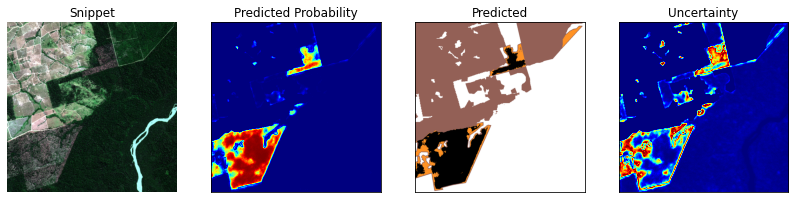

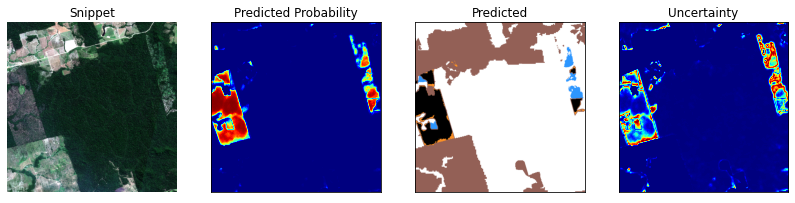

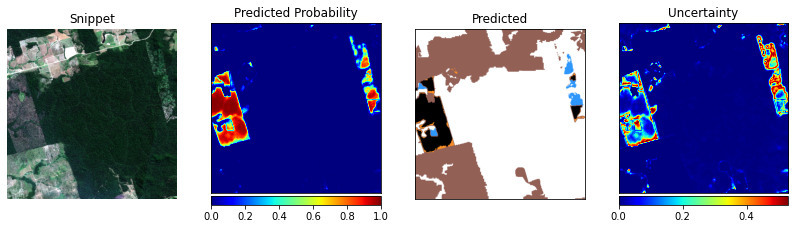

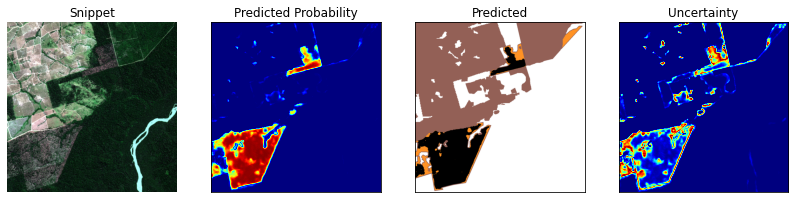

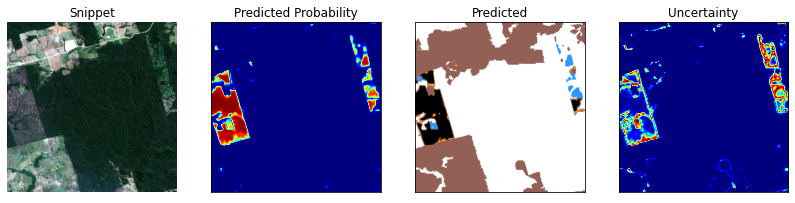

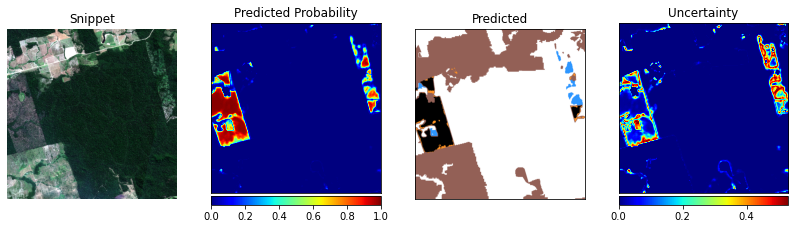

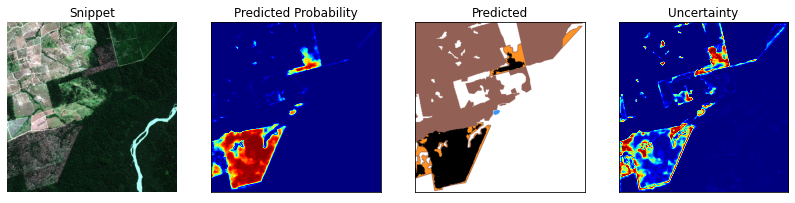

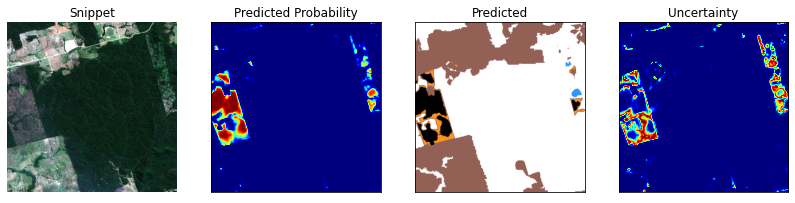

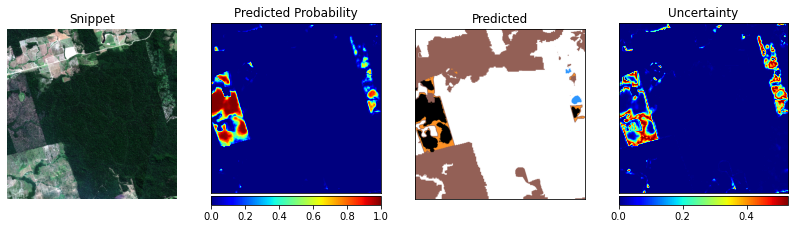

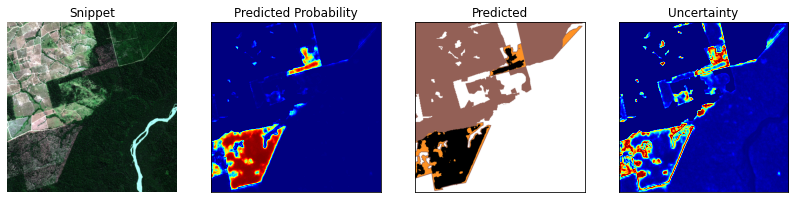

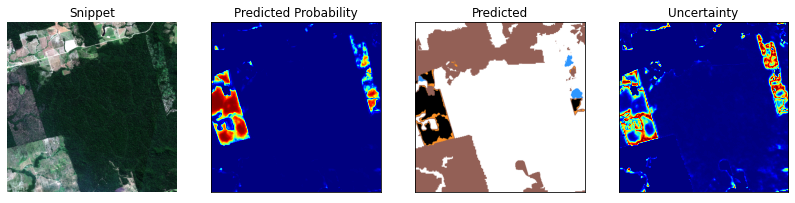

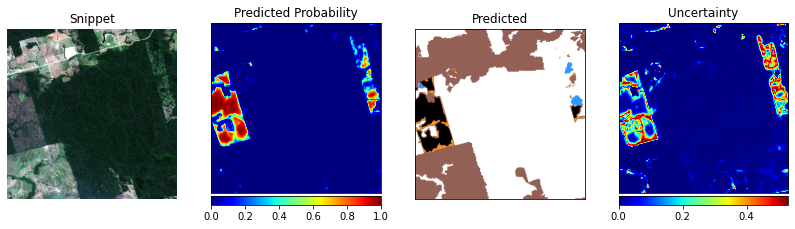

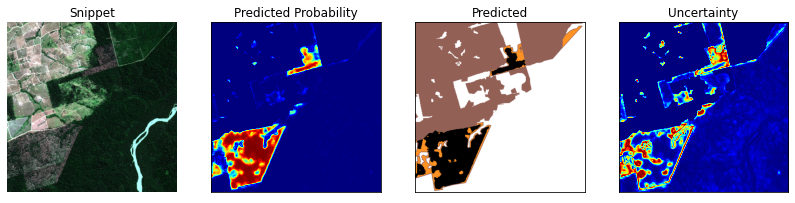

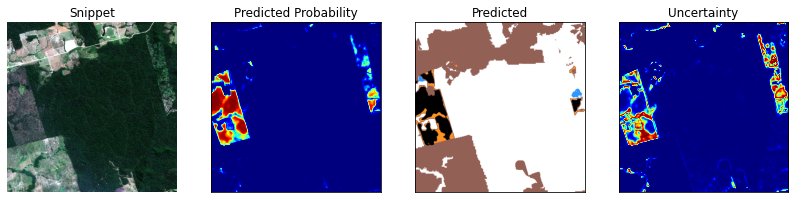

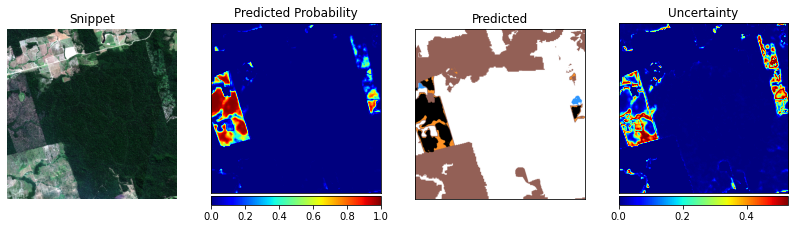

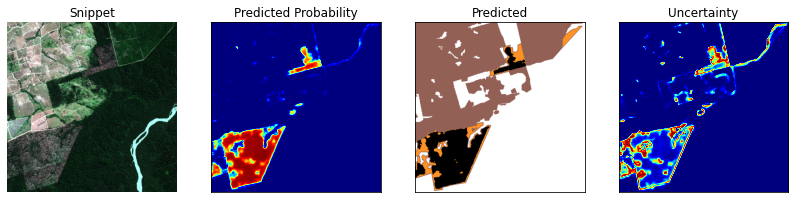

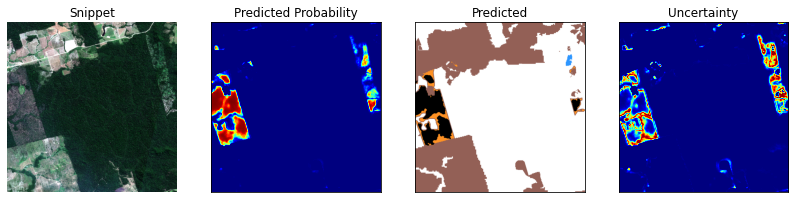

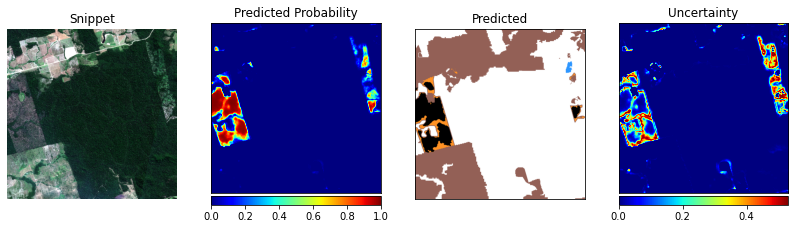

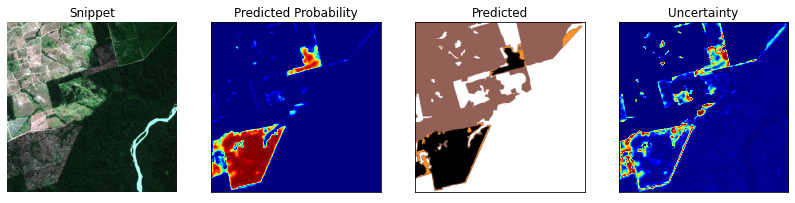

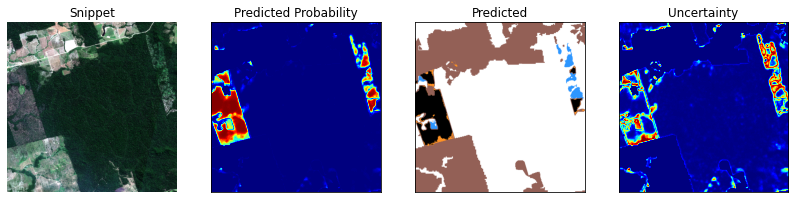

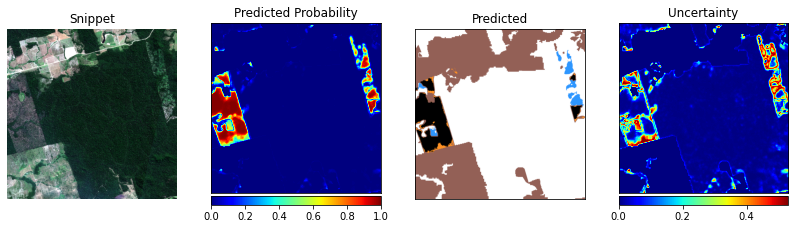

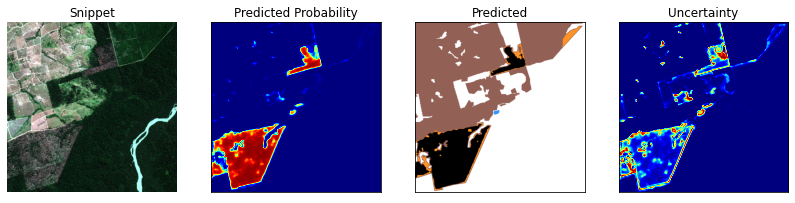

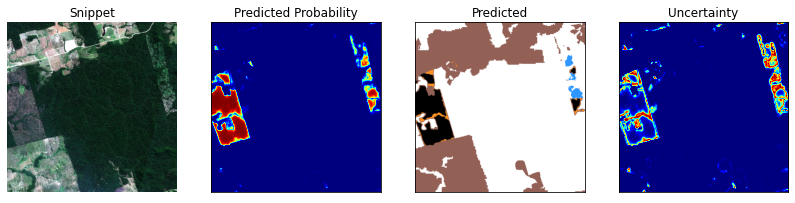

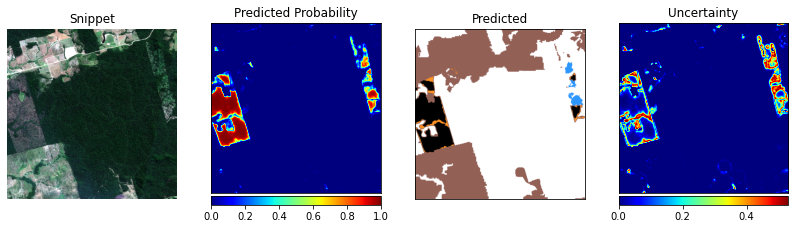

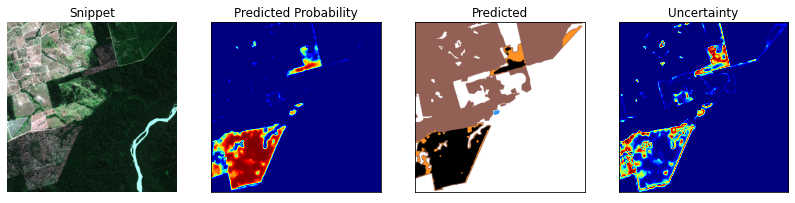

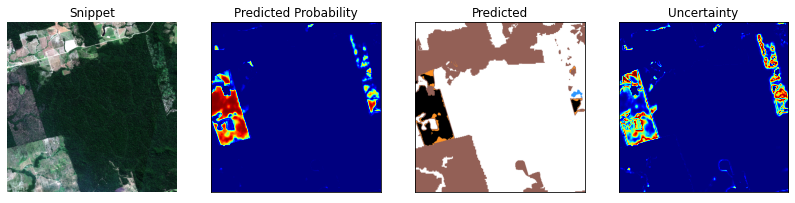

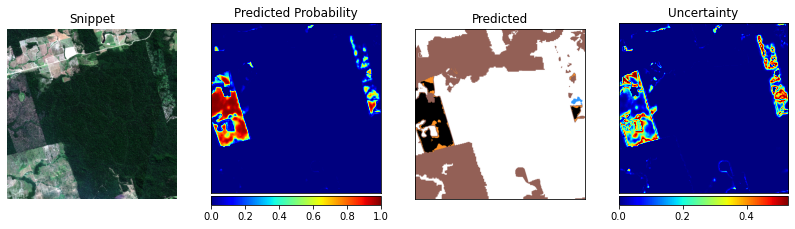

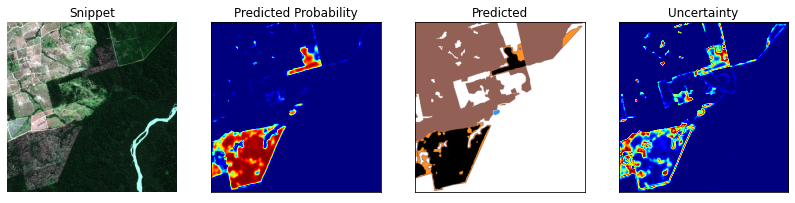

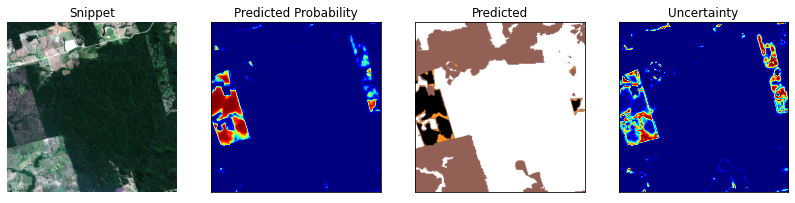

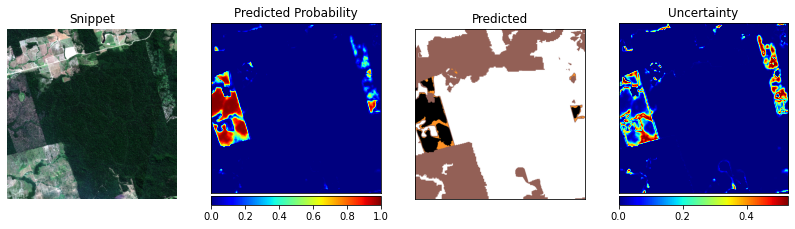

In [10]:
if config['inferring'] == True:
    idx = 0
    results = []
    error_count = 0

    while idx < len(exp_ids):
    # for experiment_value, exp_id in zip(experiment_values, exp_ids):
        try:

            print("Beginning run number {}".format(idx))
            logger = Logger()
            trainer = trainer_class(config, dataset, patchesHandler, logger)
            print("trainer.config", trainer.config)

            trainer.defineExperiment(exp_ids[idx])

            trainer.setExperimentPath()
            trainer.createLogFolders()

            trainer.loadDataset()

            # %%
            result = trainer.run_predictor()
            print("Result idx {}: {}".format(idx, result))
            results.append(result)


            with open(trainer.default_log_name, 'wb') as f:
                pickle.dump(results, f)
            print("Grid execution idx: {}".format(idx))
            idx += 1
            print("Grid execution idx: {}".format(idx))
            error_count = 0
        except Exception as e: 
            print(traceback.format_exc())
            error_count += 1
            if error_count > 10:
                sys.exit()
            print("Execution error in idx {}. Retrying...".format(idx))
            continue

In [11]:
print(results)

[{'other_uncertainty_metrics': {'sUEO': 0.686983820139951, 'ece_score': 0.02294899479640936}, 'snippet_poi_results': [{'snippet_id': 0, 'coords': [550, 550], 'reference': 0, 'predicted': array([[1.5908910e-02],
       [9.7153952e-06],
       [1.2918716e-04],
       [4.4166594e-05],
       [2.4157283e-05],
       [6.8640671e-05],
       [2.8585206e-04],
       [2.3970329e-04],
       [3.1868738e-05],
       [7.2862786e-05]], dtype=float32)}, {'snippet_id': 0, 'coords': [210, 610], 'reference': 1, 'predicted': array([[0.3473176 ],
       [0.32531524],
       [0.15975878],
       [0.24941336],
       [0.10007419],
       [0.2588972 ],
       [0.2931811 ],
       [0.35460928],
       [0.31854057],
       [0.3372865 ]], dtype=float32)}, {'snippet_id': 0, 'coords': [207, 617], 'reference': 1, 'predicted': array([[0.24558604],
       [0.09796154],
       [0.00637373],
       [0.06730682],
       [0.00271922],
       [0.07073127],
       [0.16217323],
       [0.11664302],
       [0.14139713],


In [12]:
print(len(results))

10


In [13]:
results[9]

{'other_uncertainty_metrics': {'sUEO': 0.6999953313602436,
  'ece_score': 0.011696327417649807},
 'snippet_poi_results': [{'snippet_id': 0,
   'coords': [550, 550],
   'reference': 0,
   'predicted': array([[2.68063076e-07],
          [2.24418400e-04],
          [1.35134746e-06],
          [1.42710954e-09],
          [8.57831481e-07],
          [4.19104981e-06],
          [2.10723783e-06],
          [9.03817709e-05],
          [6.33398304e-04],
          [1.02879554e-07]], dtype=float32)},
  {'snippet_id': 0,
   'coords': [210, 610],
   'reference': 1,
   'predicted': array([[0.28592718],
          [0.17068501],
          [0.2183747 ],
          [0.14592482],
          [0.07424273],
          [0.14859617],
          [0.22669576],
          [0.31450728],
          [0.29744253],
          [0.03086525]], dtype=float32)},
  {'snippet_id': 0,
   'coords': [207, 617],
   'reference': 1,
   'predicted': array([[0.06646746],
          [0.04687505],
          [0.01148244],
          [0.00304033

In [14]:
trainer.f1

73.93

In [15]:
print(trainer.f1)

73.93
